## Imports and utility functions


In [1]:


import numpy as np
import os
os.system('source ~/Downloads/cdf37_1-dist/src/definitions/definitions.K')
os.environ["CDF_LIB"] = '/home/jackalak/Downloads/cdf37_1-dist/lib'

import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
from os.path import isfile, join
from sys import getsizeof
import glob

from random import *

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

from sklearn import preprocessing
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedKFold

from pickle import dump
import joblib

# from keras import backend as K
import tensorflow.keras as k
from tensorflow.keras import utils, models, layers, optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow as tf

from scipy.stats import gaussian_kde

from ovationpyme import ovation_prime
from ovationpyme import ovation_utilities

#from nasaomnireader import omnireader
from geospacepy import omnireader, special_datetime, astrodynamics2

#import time_hist2

#import netCDF4



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/geospacepy-0.1.0-py3.6.egg/geospacepy/__init__.py", line 8, in <module>
    from geospacepy.geospacepy_config import config
ModuleNotFoundError: No module named 'geospacepy.geospacepy_config'

Solar wind data files will be saved to /home/jackalak/.local/share/geospacepy


In [2]:
print(k.__version__)
print(tf.__version__)


2.3.0-tf
2.2.0


In [3]:

def NewellCF_calc(v,bz,by):
    # v expected in km/s
    # b's expected in nT    
    NCF = np.zeros_like(v)
    NCF.fill(np.nan)
    bt = np.sqrt(by**2 + bz**2)
    bztemp = bz
    bztemp[bz == 0] = .001
    #Caculate clock angle (theta_c = t_c)
    tc = np.arctan2(by,bztemp)
    neg_tc = bt*np.cos(tc)*bz < 0 
    tc[neg_tc] = tc[neg_tc] + np.pi
    sintc = np.abs(np.sin(tc/2.))
    NCF = (v**1.33333)*(sintc**2.66667)*(bt**0.66667)
    return NCF

def nearest(items, pivot):
    #return min(items, key=lambda x: abs(x - pivot))
    return np.argmin(abs(items - pivot))


def outlier_detect_and_replace(df,str_id,outlier_value):
    """This function takes a dataframe, finds any columns 
    matching 'str_id' in the provided dataframe, and replaces
    all values that exceed the 'outlier_value' with NaN"""
#     print('working on {} outlier detection and removal'.format(str_id))
#     print('outlier value = {}'.format(outlier_value))

    cols = [ col for col in df.columns if str_id in col]
#     print('will detect and replace for columns = {}'.format(cols))
    for i in cols:
        df[i][ df[i] > outlier_value ] = np.NaN

    return df

# Metrics defined by 2019 GNSS FDL team
def dynamic_range_and_mae_loss(y_true, y_pred):
    mae = k.losses.mean_absolute_error(y_true, y_pred)
    dynamic_range_true = k.backend.max(y_true) - k.backend.min(y_true)
    dynamic_range_pred = k.backend.max(y_pred) - k.backend.min(y_pred)
    dynamic_range_loss = k.backend.abs(dynamic_range_true - dynamic_range_pred)
    dynamic_range_loss = k.backend.mean(dynamic_range_loss)
    return mae + 0.1* dynamic_range_loss

def different_exponent(y_true, y_pred):
    # |x-y|^3 with dynamic range
    mae = k.backend.pow(k.backend.abs(y_true-y_pred),3)
    mae = k.backend.mean(mae)
    dynamic_range_true = k.backend.max(y_true) - k.backend.min(y_true)
    dynamic_range_pred = k.backend.max(y_pred) - k.backend.min(y_pred)
    dynamic_range_loss = dynamic_range_true - dynamic_range_pred
    dynamic_range_loss = k.backend.mean(dynamic_range_loss)
    return mae+ 0.1* dynamic_range_loss

def tilted_loss(q,y_true,y_pred):
    e = (y_true-y_pred)
    return k.backend.mean(k.backend.maximum(q*e, (q-1)*e), axis=-1)

# def plot_box_summary(df,save_location,save_filename):
# NOTE: now use %run box_plot_summary_function.ipynb for this functionality

In [4]:
%run standard_assessment_metrics_function.ipynb

In [5]:
DMSP_FIGURE_DIR = 'DMSPdata/figures/'
DMSP_DATA_DIR = 'DMSPdata/data/'
POLAR_VIS_DATA_DIR = 'POLAR_VISdata/POLAR_VIS_Jan_25_2000/'


In [6]:
eflux_threshold_quantile = 99.995
eflux_threshold = .99995

erg_eV_factor = (1.60218e-12)

## Prepare data for ML exploration (read in full DB created from standard_ML_DB_preparation.ipynb)


In [17]:
# file_load_df_cumulative = 'ML_DB_subsamp_ext_full_dfCumulative_complexHemisphereCombine.csv'
file_load_df_cumulative = 'ML_DB_subsamp_ext_full_dfCumulative_complexHemisphereCombine.csv' #ML_DB_subsamp_ext_full_dfCumulative_complexHemisphereCombine_PCfixed.csv'
df_cumulative = pd.read_csv(os.path.join(DMSP_DATA_DIR,file_load_df_cumulative))
df_cumulative = df_cumulative.set_index('Datetimes')
df_cumulative.index = pd.to_datetime(df_cumulative.index)



In [18]:
df_cumulative.columns.to_list()

['SC_AACGM_LAT',
 'SC_AACGM_LTIME',
 'ELE_TOTAL_ENERGY_FLUX',
 'ELE_TOTAL_ENERGY_FLUX_STD',
 'ELE_AVG_ENERGY',
 'ELE_AVG_ENERGY_STD',
 'ID_SC',
 'sin_ut',
 'cos_ut',
 'sin_doy',
 'cos_doy',
 'sin_SC_AACGM_LTIME',
 'cos_SC_AACGM_LTIME',
 'F107',
 'Bz',
 'By',
 'Bx',
 'AE',
 'AL',
 'AU',
 'SymH',
 'PC',
 'vsw',
 'vx',
 'psw',
 'borovsky',
 'newell',
 'F107_6hr',
 'Bz_6hr',
 'By_6hr',
 'Bx_6hr',
 'AE_6hr',
 'AL_6hr',
 'AU_6hr',
 'SymH_6hr',
 'PC_6hr',
 'vsw_6hr',
 'vx_6hr',
 'psw_6hr',
 'borovsky_6hr',
 'newell_6hr',
 'F107_5hr',
 'Bz_5hr',
 'By_5hr',
 'Bx_5hr',
 'AE_5hr',
 'AL_5hr',
 'AU_5hr',
 'SymH_5hr',
 'PC_5hr',
 'vsw_5hr',
 'vx_5hr',
 'psw_5hr',
 'borovsky_5hr',
 'newell_5hr',
 'F107_3hr',
 'Bz_3hr',
 'By_3hr',
 'Bx_3hr',
 'AE_3hr',
 'AL_3hr',
 'AU_3hr',
 'SymH_3hr',
 'PC_3hr',
 'vsw_3hr',
 'vx_3hr',
 'psw_3hr',
 'borovsky_3hr',
 'newell_3hr',
 'F107_1hr',
 'Bz_1hr',
 'By_1hr',
 'Bx_1hr',
 'AE_1hr',
 'AL_1hr',
 'AU_1hr',
 'SymH_1hr',
 'PC_1hr',
 'vsw_1hr',
 'vx_1hr',
 'psw_1hr',
 '

In [19]:
df_cumulative_no_cols_dropped = df_cumulative.copy()

In [20]:

# df_cumulative_LTIMEs = df_cumulative_no_cols_dropped['SC_AACGM_LTIME'].copy(deep=True)
# df_cumulative_STDs = df_cumulative_no_cols_dropped['ELE_TOTAL_ENERGY_FLUX_STD'].copy(deep=True)
df_cumulative_LTIMEs = df_cumulative['SC_AACGM_LTIME'].copy(deep=True)
df_cumulative_STDs = df_cumulative['ELE_TOTAL_ENERGY_FLUX_STD'].copy(deep=True)

# cols_to_drop = [c for c in df_cumulative.columns if ('SC_AACGM_LTIME'==c)]
# cols_to_drop = [c for c in df_cumulative.columns if ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]
# cols_to_drop = [c for c in df_cumulative_no_cols_dropped.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('5min' in c) | ('15min' in c)| ('5hr' in c) | ('newell' in c) | ('borovsky' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]
# cols_to_drop = []

# Final selected set: RMM July 16, 2020
cols_to_drop = [c for c in df_cumulative.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('_5min'in c) | ('15min' in c)| ('5hr' in c) | ('F107_' in c) | ('vx' in c) | ('AE' in c) | ('newell' in c) | ('borovsky' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]
# cols_to_drop = [c for c in df_cumulative.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('_5min'in c) | ('15min' in c)| ('5hr' in c) | ('newell' in c) | ('borovsky' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]


# df_cumulative = df_cumulative_no_cols_dropped.drop(columns=cols_to_drop)
df_cumulative = df_cumulative.drop(columns=cols_to_drop)


In [21]:
df_cumulative.columns.to_list()

['SC_AACGM_LAT',
 'ELE_TOTAL_ENERGY_FLUX',
 'ID_SC',
 'sin_ut',
 'cos_ut',
 'sin_doy',
 'cos_doy',
 'sin_SC_AACGM_LTIME',
 'cos_SC_AACGM_LTIME',
 'F107',
 'Bz',
 'By',
 'Bx',
 'AL',
 'AU',
 'SymH',
 'PC',
 'vsw',
 'psw',
 'Bz_6hr',
 'By_6hr',
 'Bx_6hr',
 'AL_6hr',
 'AU_6hr',
 'SymH_6hr',
 'PC_6hr',
 'vsw_6hr',
 'psw_6hr',
 'Bz_3hr',
 'By_3hr',
 'Bx_3hr',
 'AL_3hr',
 'AU_3hr',
 'SymH_3hr',
 'PC_3hr',
 'vsw_3hr',
 'psw_3hr',
 'Bz_1hr',
 'By_1hr',
 'Bx_1hr',
 'AL_1hr',
 'AU_1hr',
 'SymH_1hr',
 'PC_1hr',
 'vsw_1hr',
 'psw_1hr',
 'Bz_45min',
 'By_45min',
 'Bx_45min',
 'AL_45min',
 'AU_45min',
 'SymH_45min',
 'PC_45min',
 'vsw_45min',
 'psw_45min',
 'Bz_30min',
 'By_30min',
 'Bx_30min',
 'AL_30min',
 'AU_30min',
 'SymH_30min',
 'PC_30min',
 'vsw_30min',
 'psw_30min',
 'Bz_10min',
 'By_10min',
 'Bx_10min',
 'AL_10min',
 'AU_10min',
 'SymH_10min',
 'PC_10min',
 'vsw_10min',
 'psw_10min']

In [22]:
print('number of input features total = {}'.format(df_cumulative.shape[1]))

number of input features total = 73


In [23]:
# Remove outliers
# idx_outliers = np.where( df_cumulative['ELE_TOTAL_ENERGY_FLUX'] > np.percentile(df_cumulative['ELE_TOTAL_ENERGY_FLUX'],99.995) )

print(df_cumulative.shape)
threshold_drop_val = np.percentile(df_cumulative['ELE_TOTAL_ENERGY_FLUX'],eflux_threshold_quantile)
print('... dropping rows where total electron energy flux is greater than {:.4E} [eV/cm2/s/ster]'.format(threshold_drop_val))
print('--------> number dropped = {}'.format(len( np.argwhere(df_cumulative['ELE_TOTAL_ENERGY_FLUX'] > threshold_drop_val) )))
df_cumulative_LTIMEs = df_cumulative_LTIMEs[ (df_cumulative['ELE_TOTAL_ENERGY_FLUX'] < threshold_drop_val) ]
df_cumulative_STDs = df_cumulative_STDs[ (df_cumulative['ELE_TOTAL_ENERGY_FLUX'] < threshold_drop_val) ]
df_cumulative = df_cumulative[ (df_cumulative['ELE_TOTAL_ENERGY_FLUX'] < threshold_drop_val) ]
print(df_cumulative.shape)

# np.where(df_cumulative['ELE_TOTAL_ENERGY_FLUX'] > np.percentile(df_cumulative['ELE_TOTAL_ENERGY_FLUX'],99.995))





(1947016, 73)
... dropping rows where total electron energy flux is greater than 7.3490E+13 [eV/cm2/s/ster]
--------> number dropped = 98


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


(1946918, 73)


In [24]:
print( 'number of input features = {}'.format( len(df_cumulative.columns.to_list()) ) )

df_cumulative.columns.to_list()

number of input features = 73


['SC_AACGM_LAT',
 'ELE_TOTAL_ENERGY_FLUX',
 'ID_SC',
 'sin_ut',
 'cos_ut',
 'sin_doy',
 'cos_doy',
 'sin_SC_AACGM_LTIME',
 'cos_SC_AACGM_LTIME',
 'F107',
 'Bz',
 'By',
 'Bx',
 'AL',
 'AU',
 'SymH',
 'PC',
 'vsw',
 'psw',
 'Bz_6hr',
 'By_6hr',
 'Bx_6hr',
 'AL_6hr',
 'AU_6hr',
 'SymH_6hr',
 'PC_6hr',
 'vsw_6hr',
 'psw_6hr',
 'Bz_3hr',
 'By_3hr',
 'Bx_3hr',
 'AL_3hr',
 'AU_3hr',
 'SymH_3hr',
 'PC_3hr',
 'vsw_3hr',
 'psw_3hr',
 'Bz_1hr',
 'By_1hr',
 'Bx_1hr',
 'AL_1hr',
 'AU_1hr',
 'SymH_1hr',
 'PC_1hr',
 'vsw_1hr',
 'psw_1hr',
 'Bz_45min',
 'By_45min',
 'Bx_45min',
 'AL_45min',
 'AU_45min',
 'SymH_45min',
 'PC_45min',
 'vsw_45min',
 'psw_45min',
 'Bz_30min',
 'By_30min',
 'Bx_30min',
 'AL_30min',
 'AU_30min',
 'SymH_30min',
 'PC_30min',
 'vsw_30min',
 'psw_30min',
 'Bz_10min',
 'By_10min',
 'Bx_10min',
 'AL_10min',
 'AU_10min',
 'SymH_10min',
 'PC_10min',
 'vsw_10min',
 'psw_10min']

In [25]:
# Separate training and testing data
# mask_val = [(df_cumulative.index.year == 2010) & (df_cumulative['ID_SC'].values==16)]
mask_val = [ ((df_cumulative.index.year == 2010) & (df_cumulative['ID_SC'].values==16)) | 
             ((df_cumulative.index.year == 2000) & (df_cumulative.index.month == 1) & (df_cumulative.index.day == 25)) ]
df_val = df_cumulative[mask_val[0]].copy(deep=True)
df_train = df_cumulative.copy(deep=True).drop( df_cumulative.index[mask_val[0]])
print('validation data shape = {}'.format(df_val.shape))
print('train data shape = {}'.format(df_train.shape))
print('NOTE: we will use CV on the train data below to define model training and testing data,\n  so have called the withheld data *validation* data here')

# Construct X and y
feature_cols = [c for c in df_cumulative.columns if not 'ELE' in c]


X_val = df_val[feature_cols].copy(deep=True)
y_val = df_val['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train[feature_cols].copy(deep=True)
y_train = df_train['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
# scaler_X = preprocessing.MinMaxScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()

validation data shape = (55210, 73)
train data shape = (1838185, 73)
NOTE: we will use CV on the train data below to define model training and testing data,
  so have called the withheld data *validation* data here


In [26]:
y_train = y_train * np.pi
y_val = y_val * np.pi
print('NOTE: removing the steradian from the DMSP data BEFORE training/n/n    ----> RMM May 28, 2020')

y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)


y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))

NOTE: removing the steradian from the DMSP data BEFORE training/n/n    ----> RMM May 28, 2020


In [27]:
# Read in OVATION Prime model data at DMSP validation data locations 
#      (created by RMM using 'OVATIONprime_atDMSPvalidationData.py' on 
#       May 22-24, 2020 using deepsun computing)
y_val_ovation = pd.read_csv(os.path.join(DMSP_DATA_DIR,'OVATIONprime_atDMSP_F16_2010_locations.csv'))
y_val_ovation = y_val_ovation.rename(columns={'Unnamed: 0':'Datetimes'})
y_val_ovation = y_val_ovation.set_index('Datetimes')
y_val_ovation.index = pd.to_datetime(y_val_ovation.index)


In [28]:
print('number of zero validation data points in OVATION = {}'.format(len(y_val_ovation['model value'][y_val_ovation['model value'] == 0.])))
      
      

number of zero validation data points in OVATION = 10893


In [29]:
y_val_ovation['model value'][y_val_ovation['model value'] == 0.] = 0.0001
y_val_ovation['model value log10(ev/cm2/s)'] = np.log10( y_val_ovation['model value']/(1.60218e-12) )

y_val_ovation = y_val_ovation.reindex(y_val_log.index)


## Interrogate the model

### Pre-step: Set constants and model construction

In [38]:
random_seed = 7

# mlepochs = 35
# batch_size = 400
# Dropout = 0.2
# learning_rate = 0.005

# JZ optimal model #3
mlepochs = 1000
batch_size = 32768
Dropout = 0.5
learning_rate = 0.001


    Working on CV fold = 0
    ----> Indices
      1987-01-12 12:57:00
      2010-12-15 05:54:00


<IPython.core.display.Javascript object>


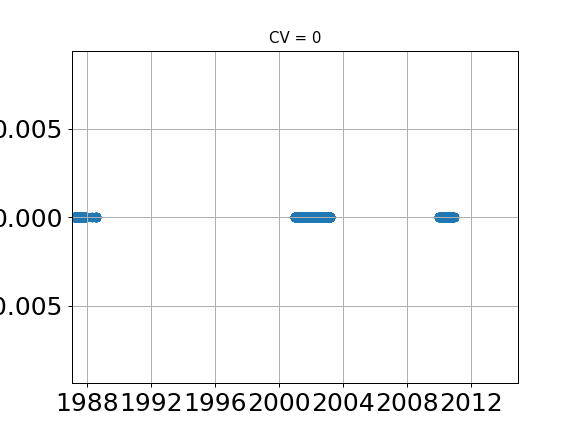

    Working on CV fold = 1
    ----> Indices
      2001-09-20 22:13:00
      2011-05-23 01:41:00


<IPython.core.display.Javascript object>


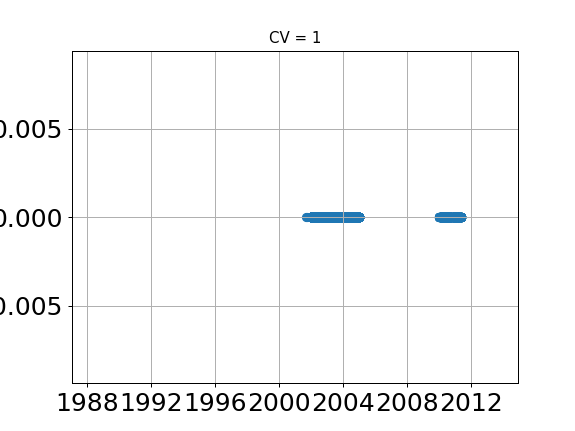

    Working on CV fold = 2
    ----> Indices
      2001-12-01 04:24:00
      2011-06-26 14:09:00


<IPython.core.display.Javascript object>


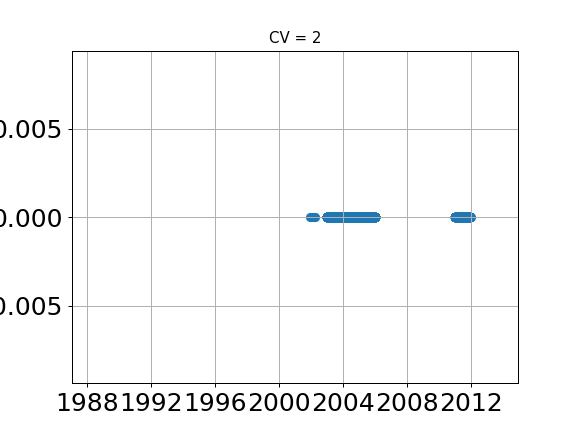

    Working on CV fold = 3
    ----> Indices
      2002-03-29 20:14:00
      2012-02-03 12:33:00


<IPython.core.display.Javascript object>


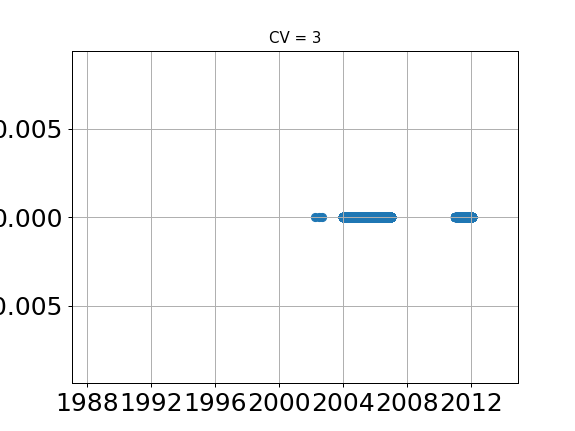

    Working on CV fold = 4
    ----> Indices
      2003-10-23 03:39:00
      2012-12-21 00:38:00


<IPython.core.display.Javascript object>


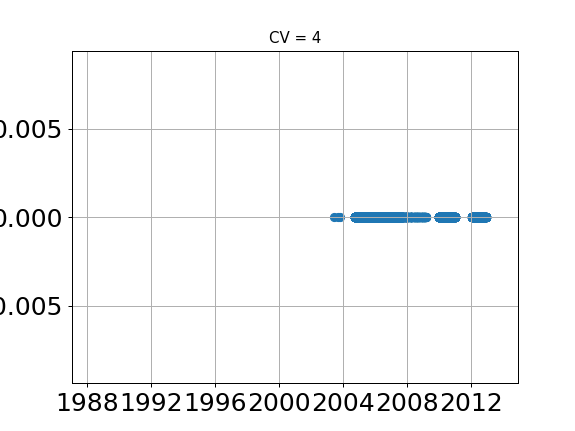

    Working on CV fold = 5
    ----> Indices
      2004-07-12 14:00:00
      2013-01-28 19:12:00


<IPython.core.display.Javascript object>


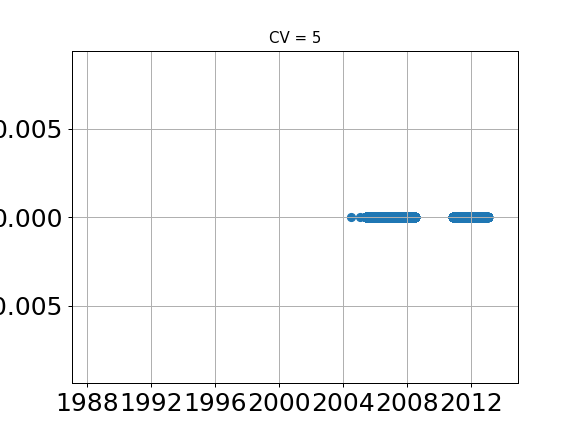

    Working on CV fold = 6
    ----> Indices
      2005-11-11 21:44:00
      2013-11-21 06:35:00


<IPython.core.display.Javascript object>


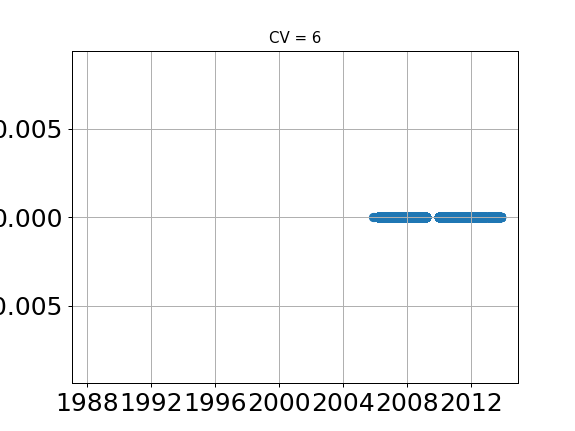

    Working on CV fold = 7
    ----> Indices
      2005-11-14 04:15:00
      2013-09-27 14:08:00


<IPython.core.display.Javascript object>


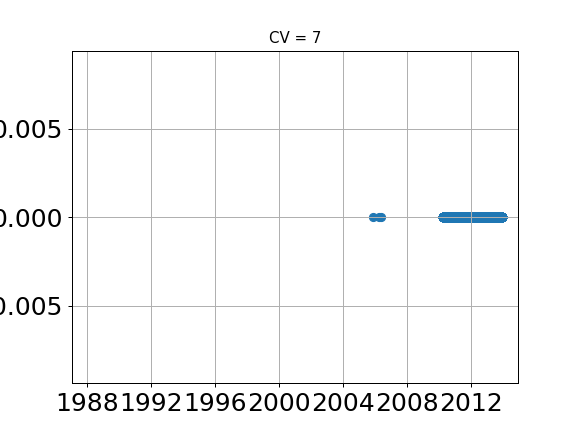

    Working on CV fold = 8
    ----> Indices
      2006-01-09 01:41:00
      2014-09-28 21:33:00


<IPython.core.display.Javascript object>


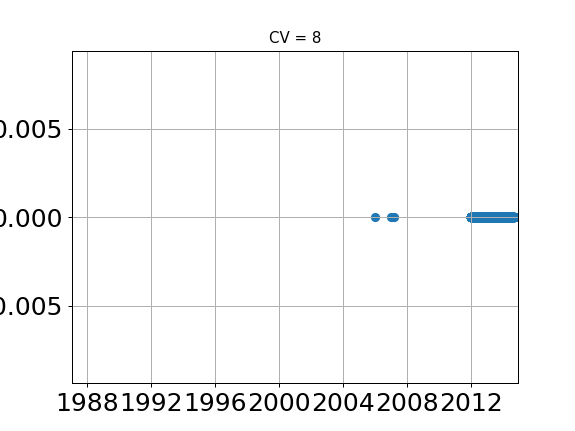

    Working on CV fold = 9
    ----> Indices
      2007-06-27 07:11:00
      2014-12-31 22:54:00


<IPython.core.display.Javascript object>


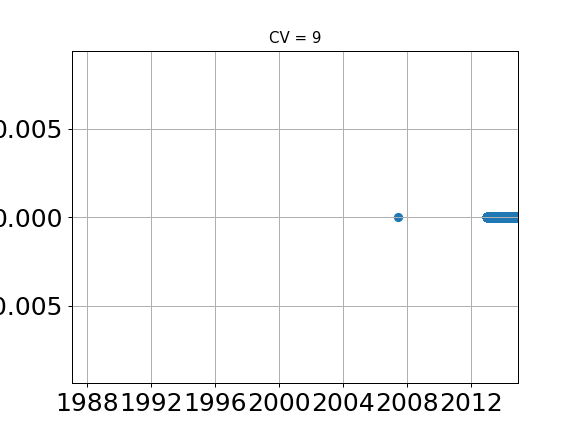

In [39]:
# Visualizing the stratified data samples

from sklearn.model_selection import StratifiedKFold
n_splits = 10
bins = np.linspace(0, 15, 15)
y_train_binned = np.digitize(y_train_log,
                             bins)

iteration = 0
skf = StratifiedKFold(n_splits=n_splits,shuffle=False)# random_state=random_seed, shuffle=False)
for train_index, test_index in skf.split(X_train.values, y_train_binned):
    print('    Working on CV fold = {}'.format(iteration))

    print('    ----> Indices\n      {}\n      {}'.format(y_train_log.index[test_index[0]],y_train_log.index[test_index[-1]]))
    print('===================')
#     plt.figure()
#     plt.hist(y_train_log[train_index].values)
#     plt.title('CV = '+str(iteration))

    plt.figure()
    plt.scatter(X_train.index[test_index],
                np.zeros(len(test_index)),
                s=40)
    plt.title('CV = '+str(iteration))
    plt.grid(True)
    plt.xlim(X_train.index[0],X_train.index[-1])
    iteration += 1

### Fit and compare cross-fold models 

In [40]:
# Create digitized y for stratified k-fold
from sklearn.model_selection import StratifiedKFold
n_splits = 10
bins = np.linspace(0, 15, 15)
y_train_binned = np.digitize(y_train_log,
                             bins)

df_CV_columns = ['CV'+str(x) for x in range(n_splits)]
df_CV = pd.DataFrame(columns=df_CV_columns,index=y_val_log.index)

df_metrics_CV_columns = ['iteration','MAE','MSE','RMSE','RAE','RSE','RSQ','linear slope','linear intercept']
df_metrics_CV_test = pd.DataFrame(columns=df_metrics_CV_columns,index=np.arange(n_splits))
df_metrics_CV_val = pd.DataFrame(columns=df_metrics_CV_columns,index=np.arange(n_splits))


# CREATE CROSS-VALIDATION SPLITS
iteration = 0
skf = StratifiedKFold(n_splits=n_splits, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X_train.values, y_train_binned):
    print('    Working on CV fold = {}'.format(iteration))

    
    # CREATE THE MODEL
#     model = k.models.Sequential()
#     model.add(k.layers.Dense(128, input_dim=X_train_scaled.shape[1], activation='selu'))
#     model.add(k.layers.AlphaDropout(Dropout))
#     model.add(k.layers.Dense(16, activation='selu'))
#     model.add(k.layers.Dense(4, activation='selu'))    
#     model.add(k.layers.Dense(1, activation='linear'))

    # JZ optimal model #3
    model = k.models.Sequential()
    model.add(k.layers.Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(k.layers.Dropout(Dropout))
    model.add(k.layers.Dense(64, activation='relu'))
    model.add(k.layers.Dense(32,activation='relu'))
    model.add(k.layers.Dense(256,activation='relu'))
    model.add(k.layers.Dense(1024,activation='relu'))
    model.add(k.layers.Dense(256, activation='relu'))
    model.add(k.layers.Dense(32, activation='relu'))
    model.add(k.layers.Dense(4, activation='relu'))    
    model.add(k.layers.Dense(1, activation='linear'))
    
    # FIT THE MODEL
    model.compile(loss='mse',
                  optimizer = k.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['logcosh','mse','mae'])
    history = model.fit(X_train_scaled[train_index],
                        y_train_log[train_index].values, 
                        epochs=mlepochs, 
                        batch_size=batch_size,
                        validation_data=(X_train_scaled[test_index], y_train_log[test_index].values), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  restore_best_weights=True,
             patience=100)])

    # PREDICT ON THE TEST AND VALIDATION DATA
    y_predict_test = model.predict(X_train_scaled[test_index])
    y_predict_val = model.predict(X_val_scaled)
    
    df_CV.iloc[:,iteration] = y_predict_val

    # CALCULATE METRICS
    MAE_test, MSE_test, RMSE_test, RAE_test, RSE_test, RSQ_test, lin_slope_test, lin_intercept_test = model_eval(y_train_log[test_index].values,y_predict_test)
    MAE_val, MSE_val, RMSE_val, RAE_val, RSE_val, RSQ_val, lin_slope_val, lin_intercept_val = model_eval(y_val_log.values,y_predict_val)

    # SAVE METRICS TO DATAFRAMES
    df_metrics_CV_test.iloc[iteration,:] = [iteration, MAE_test, MSE_test, RMSE_test, RAE_test, RSE_test, RSQ_test, lin_slope_test, lin_intercept_test]
    df_metrics_CV_val.iloc[iteration,:] = [iteration, MAE_val, MSE_val, RMSE_val, RAE_val, RSE_val, RSQ_val, lin_slope_val, lin_intercept_val]

    iteration += 1
        
        
# df_metrics_CV_test.to_csv(os.path.join(DMSP_DATA_DIR,'selfNormalizedModel_cv_results_testMetrics.csv'))
# df_metrics_CV_val.to_csv(os.path.join(DMSP_DATA_DIR,'selfNormalizedModel_cv_results_validationMetrics.csv'))
# df_CV.to_csv(os.path.join(DMSP_DATA_DIR,'selfNormalizedModel_cv_results_validationPredictions.csv'))
df_metrics_CV_test.to_csv(os.path.join(DMSP_DATA_DIR,'JZ_network3_Model_cv_results_testMetrics.csv'))
df_metrics_CV_val.to_csv(os.path.join(DMSP_DATA_DIR,'JZ_network3_Model_cv_results_validationMetrics.csv'))
df_CV.to_csv(os.path.join(DMSP_DATA_DIR,'JZ_network3_Model_cv_results_validationPredictions.csv'))
    
        
        
        

    Working on CV fold = 0
Epoch 1/1000
51/51 [==============================] - 2s 45ms/step - loss: 25.9519 - logcosh: 3.1806 - mse: 25.9519 - mae: 3.7893 - val_loss: 3.8885 - val_logcosh: 1.0176 - val_mse: 3.8885 - val_mae: 1.5507
Epoch 2/1000
51/51 [==============================] - 2s 42ms/step - loss: 1.9033 - logcosh: 0.6094 - mse: 1.9033 - mae: 1.0922 - val_loss: 1.4430 - val_logcosh: 0.5255 - val_mse: 1.4430 - val_mae: 1.0197
Epoch 3/1000
51/51 [==============================] - 2s 42ms/step - loss: 1.4533 - logcosh: 0.5120 - mse: 1.4533 - mae: 0.9863 - val_loss: 1.3012 - val_logcosh: 0.4607 - val_mse: 1.3012 - val_mae: 0.8929
Epoch 4/1000
51/51 [==============================] - 2s 44ms/step - loss: 1.3625 - logcosh: 0.4861 - mse: 1.3625 - mae: 0.9523 - val_loss: 1.2328 - val_logcosh: 0.4536 - val_mse: 1.2328 - val_mae: 0.9062
Epoch 5/1000
51/51 [==============================] - 2s 45ms/step - loss: 1.3077 - logcosh: 0.4691 - mse: 1.3077 - mae: 0.9276 - val_loss: 1.1522 - va

Epoch 41/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5590 - logcosh: 0.2198 - mse: 0.5590 - mae: 0.5577 - val_loss: 0.4925 - val_logcosh: 0.1980 - val_mse: 0.4925 - val_mae: 0.5358
Epoch 42/1000
51/51 [==============================] - 2s 43ms/step - loss: 0.5570 - logcosh: 0.2191 - mse: 0.5570 - mae: 0.5564 - val_loss: 0.4883 - val_logcosh: 0.1956 - val_mse: 0.4883 - val_mae: 0.5248
Epoch 43/1000
51/51 [==============================] - 2s 44ms/step - loss: 0.5534 - logcosh: 0.2178 - mse: 0.5534 - mae: 0.5543 - val_loss: 0.4905 - val_logcosh: 0.1961 - val_mse: 0.4905 - val_mae: 0.5221
Epoch 44/1000
51/51 [==============================] - 2s 44ms/step - loss: 0.5609 - logcosh: 0.2205 - mse: 0.5609 - mae: 0.5591 - val_loss: 0.4877 - val_logcosh: 0.1952 - val_mse: 0.4877 - val_mae: 0.5218
Epoch 45/1000
51/51 [==============================] - 2s 44ms/step - loss: 0.5523 - logcosh: 0.2173 - mse: 0.5523 - mae: 0.5536 - val_loss: 0.5202 - val_logcosh: 0.2080 - val_

Epoch 81/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5038 - logcosh: 0.1999 - mse: 0.5038 - mae: 0.5233 - val_loss: 0.4551 - val_logcosh: 0.1830 - val_mse: 0.4551 - val_mae: 0.5033
Epoch 82/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5076 - logcosh: 0.2012 - mse: 0.5076 - mae: 0.5259 - val_loss: 0.4847 - val_logcosh: 0.1939 - val_mse: 0.4847 - val_mae: 0.5273
Epoch 83/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5080 - logcosh: 0.2014 - mse: 0.5080 - mae: 0.5264 - val_loss: 0.4549 - val_logcosh: 0.1828 - val_mse: 0.4549 - val_mae: 0.5033
Epoch 84/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5109 - logcosh: 0.2023 - mse: 0.5109 - mae: 0.5279 - val_loss: 0.4604 - val_logcosh: 0.1845 - val_mse: 0.4604 - val_mae: 0.4979
Epoch 85/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.5035 - logcosh: 0.1997 - mse: 0.5035 - mae: 0.5230 - val_loss: 0.4547 - val_logcosh: 0.1823 - val_

Epoch 121/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4745 - logcosh: 0.1885 - mse: 0.4745 - mae: 0.5010 - val_loss: 0.4648 - val_logcosh: 0.1869 - val_mse: 0.4648 - val_mae: 0.5007
Epoch 122/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4745 - logcosh: 0.1884 - mse: 0.4745 - mae: 0.5005 - val_loss: 0.4557 - val_logcosh: 0.1833 - val_mse: 0.4557 - val_mae: 0.4975
Epoch 123/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4723 - logcosh: 0.1876 - mse: 0.4723 - mae: 0.4991 - val_loss: 0.4554 - val_logcosh: 0.1832 - val_mse: 0.4554 - val_mae: 0.4957
Epoch 124/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4734 - logcosh: 0.1881 - mse: 0.4734 - mae: 0.5000 - val_loss: 0.4466 - val_logcosh: 0.1800 - val_mse: 0.4466 - val_mae: 0.4937
Epoch 125/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4702 - logcosh: 0.1869 - mse: 0.4702 - mae: 0.4977 - val_loss: 0.4475 - val_logcosh: 0.1800 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4517 - logcosh: 0.1793 - mse: 0.4517 - mae: 0.4811 - val_loss: 0.4423 - val_logcosh: 0.1779 - val_mse: 0.4423 - val_mae: 0.4866
Epoch 161/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4540 - logcosh: 0.1803 - mse: 0.4540 - mae: 0.4832 - val_loss: 0.4364 - val_logcosh: 0.1761 - val_mse: 0.4364 - val_mae: 0.4937
Epoch 162/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4509 - logcosh: 0.1791 - mse: 0.4509 - mae: 0.4805 - val_loss: 0.4350 - val_logcosh: 0.1749 - val_mse: 0.4350 - val_mae: 0.4828
Epoch 163/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4518 - logcosh: 0.1794 - mse: 0.4518 - mae: 0.4813 - val_loss: 0.4360 - val_logcosh: 0.1758 - val_mse: 0.4360 - val_mae: 0.4905
Epoch 164/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4536 - logcosh: 0.1801 - mse: 0.4536 - mae: 0.4828 - val_loss: 0.4599 - val_logcosh: 0.1845 - val_mse: 0.459

Epoch 200/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4397 - logcosh: 0.1747 - mse: 0.4397 - mae: 0.4713 - val_loss: 0.4384 - val_logcosh: 0.1761 - val_mse: 0.4384 - val_mae: 0.4815
Epoch 201/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4397 - logcosh: 0.1747 - mse: 0.4397 - mae: 0.4714 - val_loss: 0.4426 - val_logcosh: 0.1776 - val_mse: 0.4426 - val_mae: 0.4824
Epoch 202/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4422 - logcosh: 0.1757 - mse: 0.4422 - mae: 0.4738 - val_loss: 0.4313 - val_logcosh: 0.1735 - val_mse: 0.4313 - val_mae: 0.4797
Epoch 203/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4388 - logcosh: 0.1743 - mse: 0.4388 - mae: 0.4708 - val_loss: 0.4381 - val_logcosh: 0.1762 - val_mse: 0.4381 - val_mae: 0.4818
Epoch 204/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4382 - logcosh: 0.1741 - mse: 0.4382 - mae: 0.4703 - val_loss: 0.4291 - val_logcosh: 0.1730 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4328 - logcosh: 0.1721 - mse: 0.4328 - mae: 0.4663 - val_loss: 0.4374 - val_logcosh: 0.1762 - val_mse: 0.4374 - val_mae: 0.4800
Epoch 240/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4327 - logcosh: 0.1720 - mse: 0.4327 - mae: 0.4660 - val_loss: 0.4308 - val_logcosh: 0.1735 - val_mse: 0.4308 - val_mae: 0.4806
Epoch 241/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4327 - logcosh: 0.1720 - mse: 0.4327 - mae: 0.4663 - val_loss: 0.4264 - val_logcosh: 0.1716 - val_mse: 0.4264 - val_mae: 0.4763
Epoch 242/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4360 - logcosh: 0.1733 - mse: 0.4360 - mae: 0.4692 - val_loss: 0.4350 - val_logcosh: 0.1750 - val_mse: 0.4350 - val_mae: 0.4780
Epoch 243/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4331 - logcosh: 0.1722 - mse: 0.4331 - mae: 0.4665 - val_loss: 0.4410 - val_logcosh: 0.1769 - val_mse: 0.441

Epoch 279/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4276 - logcosh: 0.1701 - mse: 0.4276 - mae: 0.4622 - val_loss: 0.4311 - val_logcosh: 0.1736 - val_mse: 0.4311 - val_mae: 0.4767
Epoch 280/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4274 - logcosh: 0.1700 - mse: 0.4274 - mae: 0.4621 - val_loss: 0.4289 - val_logcosh: 0.1730 - val_mse: 0.4289 - val_mae: 0.4790
Epoch 281/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4287 - logcosh: 0.1705 - mse: 0.4287 - mae: 0.4632 - val_loss: 0.4309 - val_logcosh: 0.1735 - val_mse: 0.4309 - val_mae: 0.4784
Epoch 282/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4280 - logcosh: 0.1702 - mse: 0.4280 - mae: 0.4625 - val_loss: 0.4260 - val_logcosh: 0.1713 - val_mse: 0.4260 - val_mae: 0.4739
Epoch 283/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4268 - logcosh: 0.1698 - mse: 0.4268 - mae: 0.4616 - val_loss: 0.4270 - val_logcosh: 0.1720 -

51/51 [==============================] - 2s 42ms/step - loss: 0.4249 - logcosh: 0.1690 - mse: 0.4249 - mae: 0.4602 - val_loss: 0.4304 - val_logcosh: 0.1734 - val_mse: 0.4304 - val_mae: 0.4789
Epoch 319/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4223 - logcosh: 0.1680 - mse: 0.4223 - mae: 0.4582 - val_loss: 0.4347 - val_logcosh: 0.1749 - val_mse: 0.4347 - val_mae: 0.4782
Epoch 320/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4246 - logcosh: 0.1689 - mse: 0.4246 - mae: 0.4601 - val_loss: 0.4362 - val_logcosh: 0.1750 - val_mse: 0.4362 - val_mae: 0.4794
Epoch 321/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4225 - logcosh: 0.1681 - mse: 0.4225 - mae: 0.4581 - val_loss: 0.4308 - val_logcosh: 0.1733 - val_mse: 0.4308 - val_mae: 0.4763
Epoch 322/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4223 - logcosh: 0.1680 - mse: 0.4223 - mae: 0.4580 - val_loss: 0.4285 - val_logcosh: 0.1724 - val_mse: 0.428

Epoch 358/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4230 - logcosh: 0.1683 - mse: 0.4230 - mae: 0.4589 - val_loss: 0.4447 - val_logcosh: 0.1778 - val_mse: 0.4447 - val_mae: 0.4798
Epoch 359/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4201 - logcosh: 0.1673 - mse: 0.4201 - mae: 0.4568 - val_loss: 0.4401 - val_logcosh: 0.1764 - val_mse: 0.4401 - val_mae: 0.4792
Epoch 360/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4222 - logcosh: 0.1680 - mse: 0.4222 - mae: 0.4582 - val_loss: 0.4289 - val_logcosh: 0.1725 - val_mse: 0.4289 - val_mae: 0.4810
Epoch 361/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4221 - logcosh: 0.1680 - mse: 0.4221 - mae: 0.4581 - val_loss: 0.4296 - val_logcosh: 0.1726 - val_mse: 0.4296 - val_mae: 0.4795
Epoch 362/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4199 - logcosh: 0.1671 - mse: 0.4199 - mae: 0.4562 - val_loss: 0.4272 - val_logcosh: 0.1715 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4166 - logcosh: 0.1659 - mse: 0.4166 - mae: 0.4539 - val_loss: 0.4290 - val_logcosh: 0.1726 - val_mse: 0.4290 - val_mae: 0.4760
Epoch 398/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4170 - logcosh: 0.1660 - mse: 0.4170 - mae: 0.4541 - val_loss: 0.4308 - val_logcosh: 0.1732 - val_mse: 0.4308 - val_mae: 0.4805
Epoch 399/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4181 - logcosh: 0.1665 - mse: 0.4181 - mae: 0.4555 - val_loss: 0.4255 - val_logcosh: 0.1711 - val_mse: 0.4255 - val_mae: 0.4781
Epoch 400/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4181 - logcosh: 0.1665 - mse: 0.4181 - mae: 0.4552 - val_loss: 0.4331 - val_logcosh: 0.1739 - val_mse: 0.4331 - val_mae: 0.4759
Epoch 401/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4180 - logcosh: 0.1664 - mse: 0.4180 - mae: 0.4551 - val_loss: 0.4268 - val_logcosh: 0.1715 - val_mse: 0.426

Epoch 437/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4149 - logcosh: 0.1653 - mse: 0.4149 - mae: 0.4527 - val_loss: 0.4305 - val_logcosh: 0.1730 - val_mse: 0.4305 - val_mae: 0.4796
Epoch 438/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4145 - logcosh: 0.1651 - mse: 0.4145 - mae: 0.4524 - val_loss: 0.4361 - val_logcosh: 0.1749 - val_mse: 0.4361 - val_mae: 0.4770
Epoch 439/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4147 - logcosh: 0.1652 - mse: 0.4147 - mae: 0.4526 - val_loss: 0.4302 - val_logcosh: 0.1729 - val_mse: 0.4302 - val_mae: 0.4764
Epoch 440/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4141 - logcosh: 0.1650 - mse: 0.4141 - mae: 0.4520 - val_loss: 0.4300 - val_logcosh: 0.1729 - val_mse: 0.4300 - val_mae: 0.4778
Epoch 441/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4158 - logcosh: 0.1656 - mse: 0.4158 - mae: 0.4535 - val_loss: 0.4352 - val_logcosh: 0.1744 -

Epoch 17/1000
51/51 [==============================] - 2s 43ms/step - loss: 0.6989 - logcosh: 0.2680 - mse: 0.6989 - mae: 0.6338 - val_loss: 0.5846 - val_logcosh: 0.2286 - val_mse: 0.5846 - val_mae: 0.5853
Epoch 18/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.6834 - logcosh: 0.2625 - mse: 0.6834 - mae: 0.6253 - val_loss: 0.5902 - val_logcosh: 0.2317 - val_mse: 0.5902 - val_mae: 0.5925
Epoch 19/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.6821 - logcosh: 0.2621 - mse: 0.6821 - mae: 0.6246 - val_loss: 0.5734 - val_logcosh: 0.2253 - val_mse: 0.5734 - val_mae: 0.5811
Epoch 20/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.6614 - logcosh: 0.2549 - mse: 0.6614 - mae: 0.6136 - val_loss: 0.5581 - val_logcosh: 0.2193 - val_mse: 0.5581 - val_mae: 0.5679
Epoch 21/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.6658 - logcosh: 0.2565 - mse: 0.6658 - mae: 0.6160 - val_loss: 0.5940 - val_logcosh: 0.2322 - val_

Epoch 57/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5324 - logcosh: 0.2105 - mse: 0.5324 - mae: 0.5424 - val_loss: 0.4931 - val_logcosh: 0.1937 - val_mse: 0.4931 - val_mae: 0.5224
Epoch 58/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5300 - logcosh: 0.2096 - mse: 0.5300 - mae: 0.5408 - val_loss: 0.4866 - val_logcosh: 0.1925 - val_mse: 0.4866 - val_mae: 0.5197
Epoch 59/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5320 - logcosh: 0.2102 - mse: 0.5320 - mae: 0.5419 - val_loss: 0.4864 - val_logcosh: 0.1915 - val_mse: 0.4864 - val_mae: 0.5174
Epoch 60/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5317 - logcosh: 0.2101 - mse: 0.5317 - mae: 0.5416 - val_loss: 0.4803 - val_logcosh: 0.1914 - val_mse: 0.4803 - val_mae: 0.5202
Epoch 61/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.5432 - logcosh: 0.2140 - mse: 0.5432 - mae: 0.5485 - val_loss: 0.4956 - val_logcosh: 0.1959 - val_

Epoch 97/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4931 - logcosh: 0.1959 - mse: 0.4931 - mae: 0.5159 - val_loss: 0.4627 - val_logcosh: 0.1829 - val_mse: 0.4627 - val_mae: 0.5014
Epoch 98/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4938 - logcosh: 0.1961 - mse: 0.4938 - mae: 0.5168 - val_loss: 0.4593 - val_logcosh: 0.1832 - val_mse: 0.4593 - val_mae: 0.5049
Epoch 99/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4909 - logcosh: 0.1951 - mse: 0.4909 - mae: 0.5146 - val_loss: 0.4531 - val_logcosh: 0.1808 - val_mse: 0.4531 - val_mae: 0.4974
Epoch 100/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4886 - logcosh: 0.1942 - mse: 0.4886 - mae: 0.5130 - val_loss: 0.4573 - val_logcosh: 0.1818 - val_mse: 0.4573 - val_mae: 0.4983
Epoch 101/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4936 - logcosh: 0.1960 - mse: 0.4936 - mae: 0.5164 - val_loss: 0.4639 - val_logcosh: 0.1845 - va

51/51 [==============================] - 2s 41ms/step - loss: 0.4635 - logcosh: 0.1842 - mse: 0.4635 - mae: 0.4921 - val_loss: 0.4420 - val_logcosh: 0.1758 - val_mse: 0.4420 - val_mae: 0.4864
Epoch 137/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4620 - logcosh: 0.1836 - mse: 0.4620 - mae: 0.4907 - val_loss: 0.4359 - val_logcosh: 0.1748 - val_mse: 0.4359 - val_mae: 0.4826
Epoch 138/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4681 - logcosh: 0.1859 - mse: 0.4681 - mae: 0.4955 - val_loss: 0.4409 - val_logcosh: 0.1758 - val_mse: 0.4409 - val_mae: 0.4848
Epoch 139/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4633 - logcosh: 0.1841 - mse: 0.4633 - mae: 0.4917 - val_loss: 0.4448 - val_logcosh: 0.1770 - val_mse: 0.4448 - val_mae: 0.4831
Epoch 140/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4616 - logcosh: 0.1835 - mse: 0.4616 - mae: 0.4903 - val_loss: 0.4450 - val_logcosh: 0.1771 - val_mse: 0.445

Epoch 176/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4461 - logcosh: 0.1773 - mse: 0.4461 - mae: 0.4770 - val_loss: 0.4301 - val_logcosh: 0.1724 - val_mse: 0.4301 - val_mae: 0.4793
Epoch 177/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4451 - logcosh: 0.1769 - mse: 0.4451 - mae: 0.4763 - val_loss: 0.4248 - val_logcosh: 0.1701 - val_mse: 0.4248 - val_mae: 0.4739
Epoch 178/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4485 - logcosh: 0.1781 - mse: 0.4485 - mae: 0.4789 - val_loss: 0.4300 - val_logcosh: 0.1723 - val_mse: 0.4300 - val_mae: 0.4749
Epoch 179/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4454 - logcosh: 0.1769 - mse: 0.4454 - mae: 0.4762 - val_loss: 0.4307 - val_logcosh: 0.1720 - val_mse: 0.4307 - val_mae: 0.4782
Epoch 180/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4469 - logcosh: 0.1775 - mse: 0.4469 - mae: 0.4775 - val_loss: 0.4345 - val_logcosh: 0.1735 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4354 - logcosh: 0.1731 - mse: 0.4354 - mae: 0.4685 - val_loss: 0.4272 - val_logcosh: 0.1703 - val_mse: 0.4272 - val_mae: 0.4715
Epoch 216/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4381 - logcosh: 0.1741 - mse: 0.4381 - mae: 0.4706 - val_loss: 0.4312 - val_logcosh: 0.1718 - val_mse: 0.4312 - val_mae: 0.4695
Epoch 217/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4360 - logcosh: 0.1734 - mse: 0.4360 - mae: 0.4691 - val_loss: 0.4239 - val_logcosh: 0.1699 - val_mse: 0.4239 - val_mae: 0.4692
Epoch 218/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4358 - logcosh: 0.1733 - mse: 0.4358 - mae: 0.4691 - val_loss: 0.4279 - val_logcosh: 0.1701 - val_mse: 0.4279 - val_mae: 0.4695
Epoch 219/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4337 - logcosh: 0.1725 - mse: 0.4337 - mae: 0.4670 - val_loss: 0.4293 - val_logcosh: 0.1717 - val_mse: 0.429

Epoch 255/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4285 - logcosh: 0.1705 - mse: 0.4285 - mae: 0.4631 - val_loss: 0.4283 - val_logcosh: 0.1706 - val_mse: 0.4283 - val_mae: 0.4671
Epoch 256/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4292 - logcosh: 0.1707 - mse: 0.4292 - mae: 0.4635 - val_loss: 0.4229 - val_logcosh: 0.1689 - val_mse: 0.4229 - val_mae: 0.4679
Epoch 257/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4299 - logcosh: 0.1710 - mse: 0.4299 - mae: 0.4642 - val_loss: 0.4202 - val_logcosh: 0.1680 - val_mse: 0.4202 - val_mae: 0.4646
Epoch 258/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4305 - logcosh: 0.1713 - mse: 0.4305 - mae: 0.4648 - val_loss: 0.4259 - val_logcosh: 0.1700 - val_mse: 0.4259 - val_mae: 0.4665
Epoch 259/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4292 - logcosh: 0.1707 - mse: 0.4292 - mae: 0.4637 - val_loss: 0.4248 - val_logcosh: 0.1690 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4234 - logcosh: 0.1685 - mse: 0.4234 - mae: 0.4590 - val_loss: 0.4246 - val_logcosh: 0.1686 - val_mse: 0.4246 - val_mae: 0.4651
Epoch 295/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4247 - logcosh: 0.1690 - mse: 0.4247 - mae: 0.4601 - val_loss: 0.4225 - val_logcosh: 0.1691 - val_mse: 0.4225 - val_mae: 0.4641
Epoch 296/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4238 - logcosh: 0.1687 - mse: 0.4238 - mae: 0.4595 - val_loss: 0.4234 - val_logcosh: 0.1686 - val_mse: 0.4234 - val_mae: 0.4632
Epoch 297/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4239 - logcosh: 0.1687 - mse: 0.4239 - mae: 0.4596 - val_loss: 0.4262 - val_logcosh: 0.1694 - val_mse: 0.4262 - val_mae: 0.4642
Epoch 298/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4234 - logcosh: 0.1685 - mse: 0.4234 - mae: 0.4590 - val_loss: 0.4207 - val_logcosh: 0.1674 - val_mse: 0.420

Epoch 334/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4230 - logcosh: 0.1684 - mse: 0.4230 - mae: 0.4592 - val_loss: 0.4262 - val_logcosh: 0.1689 - val_mse: 0.4262 - val_mae: 0.4625
Epoch 335/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4199 - logcosh: 0.1672 - mse: 0.4199 - mae: 0.4566 - val_loss: 0.4264 - val_logcosh: 0.1699 - val_mse: 0.4264 - val_mae: 0.4698
Epoch 336/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4200 - logcosh: 0.1672 - mse: 0.4200 - mae: 0.4564 - val_loss: 0.4343 - val_logcosh: 0.1731 - val_mse: 0.4343 - val_mae: 0.4773
Epoch 337/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4191 - logcosh: 0.1669 - mse: 0.4191 - mae: 0.4560 - val_loss: 0.4247 - val_logcosh: 0.1696 - val_mse: 0.4247 - val_mae: 0.4651
Epoch 338/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4209 - logcosh: 0.1676 - mse: 0.4209 - mae: 0.4573 - val_loss: 0.4259 - val_logcosh: 0.1698 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4168 - logcosh: 0.1661 - mse: 0.4168 - mae: 0.4543 - val_loss: 0.4210 - val_logcosh: 0.1675 - val_mse: 0.4210 - val_mae: 0.4605
Epoch 374/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4150 - logcosh: 0.1654 - mse: 0.4150 - mae: 0.4528 - val_loss: 0.4267 - val_logcosh: 0.1703 - val_mse: 0.4267 - val_mae: 0.4696
Epoch 375/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4163 - logcosh: 0.1659 - mse: 0.4163 - mae: 0.4539 - val_loss: 0.4278 - val_logcosh: 0.1704 - val_mse: 0.4278 - val_mae: 0.4661
Epoch 376/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4201 - logcosh: 0.1673 - mse: 0.4201 - mae: 0.4572 - val_loss: 0.4191 - val_logcosh: 0.1678 - val_mse: 0.4191 - val_mae: 0.4622
Epoch 377/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4150 - logcosh: 0.1653 - mse: 0.4150 - mae: 0.4526 - val_loss: 0.4208 - val_logcosh: 0.1684 - val_mse: 0.420

Epoch 413/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4117 - logcosh: 0.1642 - mse: 0.4117 - mae: 0.4505 - val_loss: 0.4220 - val_logcosh: 0.1685 - val_mse: 0.4220 - val_mae: 0.4642
Epoch 414/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4137 - logcosh: 0.1649 - mse: 0.4137 - mae: 0.4519 - val_loss: 0.4254 - val_logcosh: 0.1688 - val_mse: 0.4254 - val_mae: 0.4635
Epoch 415/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4127 - logcosh: 0.1645 - mse: 0.4127 - mae: 0.4513 - val_loss: 0.4260 - val_logcosh: 0.1701 - val_mse: 0.4260 - val_mae: 0.4680
Epoch 416/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4120 - logcosh: 0.1643 - mse: 0.4120 - mae: 0.4508 - val_loss: 0.4203 - val_logcosh: 0.1680 - val_mse: 0.4203 - val_mae: 0.4647
Epoch 417/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4127 - logcosh: 0.1645 - mse: 0.4127 - mae: 0.4513 - val_loss: 0.4260 - val_logcosh: 0.1699 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4098 - logcosh: 0.1635 - mse: 0.4098 - mae: 0.4495 - val_loss: 0.4249 - val_logcosh: 0.1697 - val_mse: 0.4249 - val_mae: 0.4644
Epoch 453/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4086 - logcosh: 0.1631 - mse: 0.4086 - mae: 0.4487 - val_loss: 0.4240 - val_logcosh: 0.1694 - val_mse: 0.4240 - val_mae: 0.4671
Epoch 454/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4090 - logcosh: 0.1632 - mse: 0.4090 - mae: 0.4487 - val_loss: 0.4302 - val_logcosh: 0.1716 - val_mse: 0.4302 - val_mae: 0.4673
Epoch 455/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4088 - logcosh: 0.1632 - mse: 0.4088 - mae: 0.4488 - val_loss: 0.4220 - val_logcosh: 0.1684 - val_mse: 0.4220 - val_mae: 0.4627
Epoch 456/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4108 - logcosh: 0.1638 - mse: 0.4108 - mae: 0.4502 - val_loss: 0.4253 - val_logcosh: 0.1699 - val_mse: 0.425

Epoch 492/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4073 - logcosh: 0.1626 - mse: 0.4073 - mae: 0.4478 - val_loss: 0.4251 - val_logcosh: 0.1696 - val_mse: 0.4251 - val_mae: 0.4655
Epoch 493/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4071 - logcosh: 0.1626 - mse: 0.4071 - mae: 0.4479 - val_loss: 0.4276 - val_logcosh: 0.1705 - val_mse: 0.4276 - val_mae: 0.4706
Epoch 494/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4070 - logcosh: 0.1625 - mse: 0.4070 - mae: 0.4476 - val_loss: 0.4314 - val_logcosh: 0.1718 - val_mse: 0.4314 - val_mae: 0.4702
Epoch 495/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4083 - logcosh: 0.1629 - mse: 0.4083 - mae: 0.4485 - val_loss: 0.4307 - val_logcosh: 0.1713 - val_mse: 0.4307 - val_mae: 0.4700
Epoch 496/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4059 - logcosh: 0.1621 - mse: 0.4059 - mae: 0.4468 - val_loss: 0.4253 - val_logcosh: 0.1693 -

Epoch 29/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.6015 - logcosh: 0.2351 - mse: 0.6015 - mae: 0.5837 - val_loss: 0.5522 - val_logcosh: 0.2117 - val_mse: 0.5522 - val_mae: 0.5426
Epoch 30/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.5888 - logcosh: 0.2305 - mse: 0.5888 - mae: 0.5762 - val_loss: 0.5715 - val_logcosh: 0.2147 - val_mse: 0.5715 - val_mae: 0.5469
Epoch 31/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.5866 - logcosh: 0.2299 - mse: 0.5866 - mae: 0.5753 - val_loss: 0.5675 - val_logcosh: 0.2156 - val_mse: 0.5675 - val_mae: 0.5515
Epoch 32/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.5875 - logcosh: 0.2300 - mse: 0.5875 - mae: 0.5754 - val_loss: 0.5580 - val_logcosh: 0.2124 - val_mse: 0.5580 - val_mae: 0.5440
Epoch 33/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.5817 - logcosh: 0.2281 - mse: 0.5817 - mae: 0.5723 - val_loss: 0.6103 - val_logcosh: 0.2263 - val_

Epoch 69/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.5212 - logcosh: 0.2064 - mse: 0.5212 - mae: 0.5360 - val_loss: 0.5014 - val_logcosh: 0.1955 - val_mse: 0.5014 - val_mae: 0.5111
Epoch 70/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.5195 - logcosh: 0.2057 - mse: 0.5195 - mae: 0.5347 - val_loss: 0.5014 - val_logcosh: 0.1954 - val_mse: 0.5014 - val_mae: 0.5133
Epoch 71/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5146 - logcosh: 0.2040 - mse: 0.5146 - mae: 0.5317 - val_loss: 0.5006 - val_logcosh: 0.1952 - val_mse: 0.5006 - val_mae: 0.5168
Epoch 72/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5184 - logcosh: 0.2054 - mse: 0.5184 - mae: 0.5344 - val_loss: 0.5079 - val_logcosh: 0.1954 - val_mse: 0.5079 - val_mae: 0.5132
Epoch 73/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5120 - logcosh: 0.2031 - mse: 0.5120 - mae: 0.5301 - val_loss: 0.5074 - val_logcosh: 0.1957 - val_

Epoch 109/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4866 - logcosh: 0.1935 - mse: 0.4866 - mae: 0.5124 - val_loss: 0.4920 - val_logcosh: 0.1894 - val_mse: 0.4920 - val_mae: 0.5035
Epoch 110/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4818 - logcosh: 0.1918 - mse: 0.4818 - mae: 0.5090 - val_loss: 0.4927 - val_logcosh: 0.1897 - val_mse: 0.4927 - val_mae: 0.5057
Epoch 111/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4808 - logcosh: 0.1913 - mse: 0.4808 - mae: 0.5079 - val_loss: 0.4896 - val_logcosh: 0.1896 - val_mse: 0.4896 - val_mae: 0.5025
Epoch 112/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4814 - logcosh: 0.1915 - mse: 0.4814 - mae: 0.5084 - val_loss: 0.5036 - val_logcosh: 0.1922 - val_mse: 0.5036 - val_mae: 0.5036
Epoch 113/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4813 - logcosh: 0.1915 - mse: 0.4813 - mae: 0.5084 - val_loss: 0.4859 - val_logcosh: 0.1885 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4590 - logcosh: 0.1825 - mse: 0.4590 - mae: 0.4891 - val_loss: 0.4569 - val_logcosh: 0.1808 - val_mse: 0.4569 - val_mae: 0.4894
Epoch 149/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4573 - logcosh: 0.1819 - mse: 0.4573 - mae: 0.4879 - val_loss: 0.4650 - val_logcosh: 0.1822 - val_mse: 0.4650 - val_mae: 0.4915
Epoch 150/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4534 - logcosh: 0.1803 - mse: 0.4534 - mae: 0.4847 - val_loss: 0.4629 - val_logcosh: 0.1839 - val_mse: 0.4629 - val_mae: 0.4988
Epoch 151/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4567 - logcosh: 0.1816 - mse: 0.4567 - mae: 0.4873 - val_loss: 0.4620 - val_logcosh: 0.1823 - val_mse: 0.4620 - val_mae: 0.4883
Epoch 152/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4534 - logcosh: 0.1803 - mse: 0.4534 - mae: 0.4844 - val_loss: 0.4721 - val_logcosh: 0.1863 - val_mse: 0.472

Epoch 188/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4388 - logcosh: 0.1745 - mse: 0.4388 - mae: 0.4720 - val_loss: 0.4510 - val_logcosh: 0.1783 - val_mse: 0.4510 - val_mae: 0.4808
Epoch 189/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4436 - logcosh: 0.1764 - mse: 0.4436 - mae: 0.4760 - val_loss: 0.4543 - val_logcosh: 0.1803 - val_mse: 0.4543 - val_mae: 0.4837
Epoch 190/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4390 - logcosh: 0.1746 - mse: 0.4390 - mae: 0.4721 - val_loss: 0.4492 - val_logcosh: 0.1775 - val_mse: 0.4492 - val_mae: 0.4797
Epoch 191/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4373 - logcosh: 0.1739 - mse: 0.4373 - mae: 0.4707 - val_loss: 0.4607 - val_logcosh: 0.1810 - val_mse: 0.4607 - val_mae: 0.4832
Epoch 192/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4411 - logcosh: 0.1754 - mse: 0.4411 - mae: 0.4740 - val_loss: 0.4616 - val_logcosh: 0.1816 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4319 - logcosh: 0.1719 - mse: 0.4319 - mae: 0.4668 - val_loss: 0.4365 - val_logcosh: 0.1737 - val_mse: 0.4365 - val_mae: 0.4735
Epoch 228/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4332 - logcosh: 0.1723 - mse: 0.4332 - mae: 0.4676 - val_loss: 0.4398 - val_logcosh: 0.1749 - val_mse: 0.4398 - val_mae: 0.4751
Epoch 229/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4307 - logcosh: 0.1713 - mse: 0.4307 - mae: 0.4653 - val_loss: 0.4442 - val_logcosh: 0.1755 - val_mse: 0.4442 - val_mae: 0.4750
Epoch 230/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4285 - logcosh: 0.1705 - mse: 0.4285 - mae: 0.4637 - val_loss: 0.4354 - val_logcosh: 0.1733 - val_mse: 0.4354 - val_mae: 0.4713
Epoch 231/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4294 - logcosh: 0.1708 - mse: 0.4294 - mae: 0.4643 - val_loss: 0.4358 - val_logcosh: 0.1736 - val_mse: 0.435

Epoch 267/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4242 - logcosh: 0.1688 - mse: 0.4242 - mae: 0.4602 - val_loss: 0.4489 - val_logcosh: 0.1766 - val_mse: 0.4489 - val_mae: 0.4763
Epoch 268/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4235 - logcosh: 0.1686 - mse: 0.4235 - mae: 0.4598 - val_loss: 0.4399 - val_logcosh: 0.1740 - val_mse: 0.4399 - val_mae: 0.4732
Epoch 269/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4261 - logcosh: 0.1696 - mse: 0.4261 - mae: 0.4621 - val_loss: 0.4500 - val_logcosh: 0.1760 - val_mse: 0.4500 - val_mae: 0.4732
Epoch 270/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4236 - logcosh: 0.1686 - mse: 0.4236 - mae: 0.4599 - val_loss: 0.4450 - val_logcosh: 0.1758 - val_mse: 0.4450 - val_mae: 0.4752
Epoch 271/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4239 - logcosh: 0.1688 - mse: 0.4239 - mae: 0.4603 - val_loss: 0.4452 - val_logcosh: 0.1755 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4202 - logcosh: 0.1674 - mse: 0.4202 - mae: 0.4576 - val_loss: 0.4383 - val_logcosh: 0.1735 - val_mse: 0.4383 - val_mae: 0.4714
Epoch 307/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4202 - logcosh: 0.1674 - mse: 0.4202 - mae: 0.4575 - val_loss: 0.4470 - val_logcosh: 0.1776 - val_mse: 0.4470 - val_mae: 0.4779
Epoch 308/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4195 - logcosh: 0.1671 - mse: 0.4195 - mae: 0.4565 - val_loss: 0.4418 - val_logcosh: 0.1750 - val_mse: 0.4418 - val_mae: 0.4743
Epoch 309/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4200 - logcosh: 0.1673 - mse: 0.4200 - mae: 0.4572 - val_loss: 0.4495 - val_logcosh: 0.1770 - val_mse: 0.4495 - val_mae: 0.4793
Epoch 310/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4217 - logcosh: 0.1679 - mse: 0.4217 - mae: 0.4588 - val_loss: 0.4417 - val_logcosh: 0.1753 - val_mse: 0.441

Epoch 346/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4162 - logcosh: 0.1659 - mse: 0.4162 - mae: 0.4544 - val_loss: 0.4495 - val_logcosh: 0.1774 - val_mse: 0.4495 - val_mae: 0.4785
Epoch 347/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4175 - logcosh: 0.1664 - mse: 0.4175 - mae: 0.4557 - val_loss: 0.4431 - val_logcosh: 0.1759 - val_mse: 0.4431 - val_mae: 0.4763
Epoch 348/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4154 - logcosh: 0.1656 - mse: 0.4154 - mae: 0.4538 - val_loss: 0.4559 - val_logcosh: 0.1804 - val_mse: 0.4559 - val_mae: 0.4819
Epoch 349/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4171 - logcosh: 0.1663 - mse: 0.4171 - mae: 0.4555 - val_loss: 0.4496 - val_logcosh: 0.1773 - val_mse: 0.4496 - val_mae: 0.4767
Epoch 350/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4149 - logcosh: 0.1654 - mse: 0.4149 - mae: 0.4535 - val_loss: 0.4580 - val_logcosh: 0.1799 -

Epoch 2/1000
51/51 [==============================] - 2s 41ms/step - loss: 3.7777 - logcosh: 0.9605 - mse: 3.7777 - mae: 1.4799 - val_loss: 1.4897 - val_logcosh: 0.4951 - val_mse: 1.4897 - val_mae: 0.9245
Epoch 3/1000
51/51 [==============================] - 2s 41ms/step - loss: 1.5315 - logcosh: 0.5212 - mse: 1.5315 - mae: 0.9943 - val_loss: 1.2136 - val_logcosh: 0.4474 - val_mse: 1.2136 - val_mae: 0.9074
Epoch 4/1000
51/51 [==============================] - 2s 41ms/step - loss: 1.4197 - logcosh: 0.4902 - mse: 1.4197 - mae: 0.9545 - val_loss: 1.1398 - val_logcosh: 0.4250 - val_mse: 1.1398 - val_mae: 0.8757
Epoch 5/1000
51/51 [==============================] - 2s 42ms/step - loss: 1.3456 - logcosh: 0.4674 - mse: 1.3456 - mae: 0.9232 - val_loss: 1.0813 - val_logcosh: 0.4074 - val_mse: 1.0813 - val_mae: 0.8510
Epoch 6/1000
51/51 [==============================] - 2s 41ms/step - loss: 1.2959 - logcosh: 0.4509 - mse: 1.2959 - mae: 0.8992 - val_loss: 1.0153 - val_logcosh: 0.3848 - val_mse: 

Epoch 42/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5584 - logcosh: 0.2196 - mse: 0.5584 - mae: 0.5581 - val_loss: 0.4749 - val_logcosh: 0.1890 - val_mse: 0.4749 - val_mae: 0.5023
Epoch 43/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.5690 - logcosh: 0.2233 - mse: 0.5690 - mae: 0.5644 - val_loss: 0.4832 - val_logcosh: 0.1924 - val_mse: 0.4832 - val_mae: 0.5065
Epoch 44/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5595 - logcosh: 0.2201 - mse: 0.5595 - mae: 0.5591 - val_loss: 0.4725 - val_logcosh: 0.1884 - val_mse: 0.4725 - val_mae: 0.5032
Epoch 45/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.5520 - logcosh: 0.2174 - mse: 0.5520 - mae: 0.5545 - val_loss: 0.4716 - val_logcosh: 0.1883 - val_mse: 0.4716 - val_mae: 0.5039
Epoch 46/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.5528 - logcosh: 0.2177 - mse: 0.5528 - mae: 0.5550 - val_loss: 0.4753 - val_logcosh: 0.1895 - val_

Epoch 82/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5133 - logcosh: 0.2035 - mse: 0.5133 - mae: 0.5310 - val_loss: 0.4523 - val_logcosh: 0.1806 - val_mse: 0.4523 - val_mae: 0.4893
Epoch 83/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5052 - logcosh: 0.2006 - mse: 0.5052 - mae: 0.5255 - val_loss: 0.4523 - val_logcosh: 0.1803 - val_mse: 0.4523 - val_mae: 0.4884
Epoch 84/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.5036 - logcosh: 0.1999 - mse: 0.5036 - mae: 0.5242 - val_loss: 0.4549 - val_logcosh: 0.1818 - val_mse: 0.4549 - val_mae: 0.4957
Epoch 85/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.5068 - logcosh: 0.2011 - mse: 0.5068 - mae: 0.5262 - val_loss: 0.4636 - val_logcosh: 0.1846 - val_mse: 0.4636 - val_mae: 0.4919
Epoch 86/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5045 - logcosh: 0.2002 - mse: 0.5045 - mae: 0.5245 - val_loss: 0.4544 - val_logcosh: 0.1814 - val_

Epoch 122/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4727 - logcosh: 0.1879 - mse: 0.4727 - mae: 0.5002 - val_loss: 0.4468 - val_logcosh: 0.1781 - val_mse: 0.4468 - val_mae: 0.4806
Epoch 123/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4713 - logcosh: 0.1874 - mse: 0.4713 - mae: 0.4992 - val_loss: 0.4431 - val_logcosh: 0.1766 - val_mse: 0.4431 - val_mae: 0.4833
Epoch 124/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4716 - logcosh: 0.1874 - mse: 0.4716 - mae: 0.4991 - val_loss: 0.4551 - val_logcosh: 0.1811 - val_mse: 0.4551 - val_mae: 0.4847
Epoch 125/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4707 - logcosh: 0.1871 - mse: 0.4707 - mae: 0.4988 - val_loss: 0.4432 - val_logcosh: 0.1767 - val_mse: 0.4432 - val_mae: 0.4839
Epoch 126/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4709 - logcosh: 0.1872 - mse: 0.4709 - mae: 0.4989 - val_loss: 0.4448 - val_logcosh: 0.1769 -

51/51 [==============================] - 2s 42ms/step - loss: 0.4490 - logcosh: 0.1785 - mse: 0.4490 - mae: 0.4800 - val_loss: 0.4354 - val_logcosh: 0.1735 - val_mse: 0.4354 - val_mae: 0.4741
Epoch 162/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4491 - logcosh: 0.1785 - mse: 0.4491 - mae: 0.4801 - val_loss: 0.4390 - val_logcosh: 0.1745 - val_mse: 0.4390 - val_mae: 0.4776
Epoch 163/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4515 - logcosh: 0.1794 - mse: 0.4515 - mae: 0.4820 - val_loss: 0.4431 - val_logcosh: 0.1769 - val_mse: 0.4431 - val_mae: 0.4844
Epoch 164/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4498 - logcosh: 0.1787 - mse: 0.4498 - mae: 0.4805 - val_loss: 0.4376 - val_logcosh: 0.1751 - val_mse: 0.4376 - val_mae: 0.4794
Epoch 165/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4511 - logcosh: 0.1792 - mse: 0.4511 - mae: 0.4815 - val_loss: 0.4354 - val_logcosh: 0.1736 - val_mse: 0.435

Epoch 201/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4402 - logcosh: 0.1749 - mse: 0.4402 - mae: 0.4722 - val_loss: 0.4343 - val_logcosh: 0.1729 - val_mse: 0.4343 - val_mae: 0.4718
Epoch 202/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4395 - logcosh: 0.1746 - mse: 0.4395 - mae: 0.4717 - val_loss: 0.4320 - val_logcosh: 0.1726 - val_mse: 0.4320 - val_mae: 0.4730
Epoch 203/1000
51/51 [==============================] - 2s 45ms/step - loss: 0.4385 - logcosh: 0.1743 - mse: 0.4385 - mae: 0.4709 - val_loss: 0.4333 - val_logcosh: 0.1728 - val_mse: 0.4333 - val_mae: 0.4729
Epoch 204/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4425 - logcosh: 0.1757 - mse: 0.4425 - mae: 0.4741 - val_loss: 0.4358 - val_logcosh: 0.1735 - val_mse: 0.4358 - val_mae: 0.4708
Epoch 205/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4425 - logcosh: 0.1758 - mse: 0.4425 - mae: 0.4744 - val_loss: 0.4401 - val_logcosh: 0.1758 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4312 - logcosh: 0.1715 - mse: 0.4312 - mae: 0.4651 - val_loss: 0.4397 - val_logcosh: 0.1753 - val_mse: 0.4397 - val_mae: 0.4738
Epoch 241/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4323 - logcosh: 0.1719 - mse: 0.4323 - mae: 0.4661 - val_loss: 0.4327 - val_logcosh: 0.1726 - val_mse: 0.4327 - val_mae: 0.4704
Epoch 242/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4350 - logcosh: 0.1730 - mse: 0.4350 - mae: 0.4687 - val_loss: 0.4321 - val_logcosh: 0.1727 - val_mse: 0.4321 - val_mae: 0.4712
Epoch 243/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4318 - logcosh: 0.1717 - mse: 0.4318 - mae: 0.4658 - val_loss: 0.4333 - val_logcosh: 0.1727 - val_mse: 0.4333 - val_mae: 0.4711
Epoch 244/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4307 - logcosh: 0.1713 - mse: 0.4307 - mae: 0.4646 - val_loss: 0.4341 - val_logcosh: 0.1730 - val_mse: 0.434

Epoch 280/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4258 - logcosh: 0.1694 - mse: 0.4258 - mae: 0.4608 - val_loss: 0.4317 - val_logcosh: 0.1724 - val_mse: 0.4317 - val_mae: 0.4719
Epoch 281/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4283 - logcosh: 0.1704 - mse: 0.4283 - mae: 0.4630 - val_loss: 0.4312 - val_logcosh: 0.1720 - val_mse: 0.4312 - val_mae: 0.4700
Epoch 282/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4273 - logcosh: 0.1699 - mse: 0.4273 - mae: 0.4621 - val_loss: 0.4336 - val_logcosh: 0.1727 - val_mse: 0.4336 - val_mae: 0.4726
Epoch 283/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4251 - logcosh: 0.1691 - mse: 0.4251 - mae: 0.4604 - val_loss: 0.4328 - val_logcosh: 0.1732 - val_mse: 0.4328 - val_mae: 0.4759
Epoch 284/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4282 - logcosh: 0.1703 - mse: 0.4282 - mae: 0.4631 - val_loss: 0.4296 - val_logcosh: 0.1716 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4212 - logcosh: 0.1676 - mse: 0.4212 - mae: 0.4574 - val_loss: 0.4336 - val_logcosh: 0.1730 - val_mse: 0.4336 - val_mae: 0.4741
Epoch 320/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4219 - logcosh: 0.1679 - mse: 0.4219 - mae: 0.4581 - val_loss: 0.4364 - val_logcosh: 0.1749 - val_mse: 0.4364 - val_mae: 0.4748
Epoch 321/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4230 - logcosh: 0.1683 - mse: 0.4230 - mae: 0.4589 - val_loss: 0.4309 - val_logcosh: 0.1720 - val_mse: 0.4309 - val_mae: 0.4716
Epoch 322/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4213 - logcosh: 0.1677 - mse: 0.4213 - mae: 0.4574 - val_loss: 0.4338 - val_logcosh: 0.1739 - val_mse: 0.4338 - val_mae: 0.4778
Epoch 323/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4214 - logcosh: 0.1677 - mse: 0.4214 - mae: 0.4575 - val_loss: 0.4317 - val_logcosh: 0.1726 - val_mse: 0.431

Epoch 359/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4184 - logcosh: 0.1666 - mse: 0.4184 - mae: 0.4554 - val_loss: 0.4322 - val_logcosh: 0.1732 - val_mse: 0.4322 - val_mae: 0.4723
Epoch 360/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4182 - logcosh: 0.1666 - mse: 0.4182 - mae: 0.4555 - val_loss: 0.4304 - val_logcosh: 0.1723 - val_mse: 0.4304 - val_mae: 0.4711
Epoch 361/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4191 - logcosh: 0.1669 - mse: 0.4191 - mae: 0.4560 - val_loss: 0.4312 - val_logcosh: 0.1725 - val_mse: 0.4312 - val_mae: 0.4703
Epoch 362/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4193 - logcosh: 0.1670 - mse: 0.4193 - mae: 0.4565 - val_loss: 0.4333 - val_logcosh: 0.1733 - val_mse: 0.4333 - val_mae: 0.4768
Epoch 363/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4179 - logcosh: 0.1664 - mse: 0.4179 - mae: 0.4552 - val_loss: 0.4329 - val_logcosh: 0.1732 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4158 - logcosh: 0.1657 - mse: 0.4158 - mae: 0.4539 - val_loss: 0.4343 - val_logcosh: 0.1736 - val_mse: 0.4343 - val_mae: 0.4724
Epoch 399/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4160 - logcosh: 0.1657 - mse: 0.4160 - mae: 0.4540 - val_loss: 0.4325 - val_logcosh: 0.1731 - val_mse: 0.4325 - val_mae: 0.4719
Epoch 400/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4159 - logcosh: 0.1657 - mse: 0.4159 - mae: 0.4538 - val_loss: 0.4330 - val_logcosh: 0.1732 - val_mse: 0.4330 - val_mae: 0.4741
Epoch 401/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4160 - logcosh: 0.1658 - mse: 0.4160 - mae: 0.4540 - val_loss: 0.4291 - val_logcosh: 0.1715 - val_mse: 0.4291 - val_mae: 0.4695
Epoch 402/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4151 - logcosh: 0.1654 - mse: 0.4151 - mae: 0.4533 - val_loss: 0.4313 - val_logcosh: 0.1723 - val_mse: 0.431

Epoch 4/1000
51/51 [==============================] - 2s 42ms/step - loss: 1.3649 - logcosh: 0.4880 - mse: 1.3649 - mae: 0.9544 - val_loss: 1.2395 - val_logcosh: 0.4609 - val_mse: 1.2395 - val_mae: 0.9343
Epoch 5/1000
51/51 [==============================] - 2s 42ms/step - loss: 1.3199 - logcosh: 0.4725 - mse: 1.3199 - mae: 0.9313 - val_loss: 1.1792 - val_logcosh: 0.4302 - val_mse: 1.1792 - val_mae: 0.8725
Epoch 6/1000
51/51 [==============================] - 2s 42ms/step - loss: 1.2458 - logcosh: 0.4511 - mse: 1.2458 - mae: 0.9033 - val_loss: 1.1029 - val_logcosh: 0.4154 - val_mse: 1.1029 - val_mae: 0.8649
Epoch 7/1000
51/51 [==============================] - 2s 42ms/step - loss: 1.1923 - logcosh: 0.4350 - mse: 1.1923 - mae: 0.8818 - val_loss: 1.0781 - val_logcosh: 0.3943 - val_mse: 1.0781 - val_mae: 0.8150
Epoch 8/1000
51/51 [==============================] - 2s 42ms/step - loss: 1.1860 - logcosh: 0.4283 - mse: 1.1860 - mae: 0.8680 - val_loss: 0.9437 - val_logcosh: 0.3604 - val_mse: 

Epoch 44/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.5592 - logcosh: 0.2199 - mse: 0.5592 - mae: 0.5590 - val_loss: 0.5393 - val_logcosh: 0.2113 - val_mse: 0.5393 - val_mae: 0.5348
Epoch 45/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5599 - logcosh: 0.2202 - mse: 0.5599 - mae: 0.5596 - val_loss: 0.5009 - val_logcosh: 0.1979 - val_mse: 0.5009 - val_mae: 0.5177
Epoch 46/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5507 - logcosh: 0.2172 - mse: 0.5507 - mae: 0.5547 - val_loss: 0.4982 - val_logcosh: 0.1961 - val_mse: 0.4982 - val_mae: 0.5112
Epoch 47/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5535 - logcosh: 0.2181 - mse: 0.5535 - mae: 0.5560 - val_loss: 0.4995 - val_logcosh: 0.1969 - val_mse: 0.4995 - val_mae: 0.5116
Epoch 48/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5514 - logcosh: 0.2174 - mse: 0.5514 - mae: 0.5549 - val_loss: 0.4990 - val_logcosh: 0.1968 - val_

Epoch 84/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5066 - logcosh: 0.2011 - mse: 0.5066 - mae: 0.5266 - val_loss: 0.4778 - val_logcosh: 0.1883 - val_mse: 0.4778 - val_mae: 0.4942
Epoch 85/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.5030 - logcosh: 0.1996 - mse: 0.5030 - mae: 0.5240 - val_loss: 0.4759 - val_logcosh: 0.1873 - val_mse: 0.4759 - val_mae: 0.4920
Epoch 86/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5008 - logcosh: 0.1988 - mse: 0.5008 - mae: 0.5222 - val_loss: 0.4771 - val_logcosh: 0.1878 - val_mse: 0.4771 - val_mae: 0.4928
Epoch 87/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5049 - logcosh: 0.2003 - mse: 0.5049 - mae: 0.5249 - val_loss: 0.4723 - val_logcosh: 0.1865 - val_mse: 0.4723 - val_mae: 0.4932
Epoch 88/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5010 - logcosh: 0.1989 - mse: 0.5010 - mae: 0.5226 - val_loss: 0.4724 - val_logcosh: 0.1866 - val_

Epoch 124/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4725 - logcosh: 0.1878 - mse: 0.4725 - mae: 0.5006 - val_loss: 0.4610 - val_logcosh: 0.1818 - val_mse: 0.4610 - val_mae: 0.4835
Epoch 125/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4738 - logcosh: 0.1884 - mse: 0.4738 - mae: 0.5018 - val_loss: 0.4600 - val_logcosh: 0.1815 - val_mse: 0.4600 - val_mae: 0.4824
Epoch 126/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4724 - logcosh: 0.1878 - mse: 0.4724 - mae: 0.5005 - val_loss: 0.4696 - val_logcosh: 0.1850 - val_mse: 0.4696 - val_mae: 0.4864
Epoch 127/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4709 - logcosh: 0.1872 - mse: 0.4709 - mae: 0.4993 - val_loss: 0.4612 - val_logcosh: 0.1820 - val_mse: 0.4612 - val_mae: 0.4820
Epoch 128/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4679 - logcosh: 0.1861 - mse: 0.4679 - mae: 0.4973 - val_loss: 0.4653 - val_logcosh: 0.1831 -

51/51 [==============================] - 2s 42ms/step - loss: 0.4532 - logcosh: 0.1800 - mse: 0.4532 - mae: 0.4838 - val_loss: 0.4570 - val_logcosh: 0.1800 - val_mse: 0.4570 - val_mae: 0.4804
Epoch 164/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4481 - logcosh: 0.1780 - mse: 0.4481 - mae: 0.4794 - val_loss: 0.4579 - val_logcosh: 0.1800 - val_mse: 0.4579 - val_mae: 0.4756
Epoch 165/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4490 - logcosh: 0.1784 - mse: 0.4490 - mae: 0.4803 - val_loss: 0.4551 - val_logcosh: 0.1788 - val_mse: 0.4551 - val_mae: 0.4748
Epoch 166/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4458 - logcosh: 0.1772 - mse: 0.4458 - mae: 0.4777 - val_loss: 0.4557 - val_logcosh: 0.1786 - val_mse: 0.4557 - val_mae: 0.4723
Epoch 167/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4473 - logcosh: 0.1777 - mse: 0.4473 - mae: 0.4789 - val_loss: 0.4555 - val_logcosh: 0.1796 - val_mse: 0.455

Epoch 203/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4365 - logcosh: 0.1736 - mse: 0.4365 - mae: 0.4704 - val_loss: 0.4581 - val_logcosh: 0.1806 - val_mse: 0.4581 - val_mae: 0.4796
Epoch 204/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4365 - logcosh: 0.1735 - mse: 0.4365 - mae: 0.4702 - val_loss: 0.4571 - val_logcosh: 0.1795 - val_mse: 0.4571 - val_mae: 0.4751
Epoch 205/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4389 - logcosh: 0.1744 - mse: 0.4389 - mae: 0.4721 - val_loss: 0.4585 - val_logcosh: 0.1803 - val_mse: 0.4585 - val_mae: 0.4769
Epoch 206/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4361 - logcosh: 0.1734 - mse: 0.4361 - mae: 0.4700 - val_loss: 0.4649 - val_logcosh: 0.1825 - val_mse: 0.4649 - val_mae: 0.4802
Epoch 207/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4353 - logcosh: 0.1731 - mse: 0.4353 - mae: 0.4692 - val_loss: 0.4541 - val_logcosh: 0.1788 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4304 - logcosh: 0.1712 - mse: 0.4304 - mae: 0.4652 - val_loss: 0.4538 - val_logcosh: 0.1789 - val_mse: 0.4538 - val_mae: 0.4767
Epoch 243/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4302 - logcosh: 0.1711 - mse: 0.4302 - mae: 0.4652 - val_loss: 0.4548 - val_logcosh: 0.1782 - val_mse: 0.4548 - val_mae: 0.4721
Epoch 244/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4295 - logcosh: 0.1708 - mse: 0.4295 - mae: 0.4647 - val_loss: 0.4520 - val_logcosh: 0.1780 - val_mse: 0.4520 - val_mae: 0.4748
Epoch 245/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4306 - logcosh: 0.1713 - mse: 0.4306 - mae: 0.4657 - val_loss: 0.4528 - val_logcosh: 0.1779 - val_mse: 0.4528 - val_mae: 0.4727
Epoch 246/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4301 - logcosh: 0.1711 - mse: 0.4301 - mae: 0.4652 - val_loss: 0.4610 - val_logcosh: 0.1807 - val_mse: 0.461

Epoch 282/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4245 - logcosh: 0.1689 - mse: 0.4245 - mae: 0.4608 - val_loss: 0.4523 - val_logcosh: 0.1781 - val_mse: 0.4523 - val_mae: 0.4743
Epoch 283/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4231 - logcosh: 0.1685 - mse: 0.4231 - mae: 0.4599 - val_loss: 0.4520 - val_logcosh: 0.1779 - val_mse: 0.4520 - val_mae: 0.4756
Epoch 284/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4232 - logcosh: 0.1685 - mse: 0.4232 - mae: 0.4597 - val_loss: 0.4530 - val_logcosh: 0.1781 - val_mse: 0.4530 - val_mae: 0.4735
Epoch 285/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4228 - logcosh: 0.1683 - mse: 0.4228 - mae: 0.4596 - val_loss: 0.4511 - val_logcosh: 0.1773 - val_mse: 0.4511 - val_mae: 0.4715
Epoch 286/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4232 - logcosh: 0.1685 - mse: 0.4232 - mae: 0.4597 - val_loss: 0.4531 - val_logcosh: 0.1775 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4207 - logcosh: 0.1675 - mse: 0.4207 - mae: 0.4581 - val_loss: 0.4527 - val_logcosh: 0.1785 - val_mse: 0.4527 - val_mae: 0.4746
Epoch 322/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4185 - logcosh: 0.1667 - mse: 0.4185 - mae: 0.4561 - val_loss: 0.4487 - val_logcosh: 0.1762 - val_mse: 0.4487 - val_mae: 0.4685
Epoch 323/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4196 - logcosh: 0.1671 - mse: 0.4196 - mae: 0.4572 - val_loss: 0.4531 - val_logcosh: 0.1787 - val_mse: 0.4531 - val_mae: 0.4788
Epoch 324/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4191 - logcosh: 0.1669 - mse: 0.4191 - mae: 0.4568 - val_loss: 0.4482 - val_logcosh: 0.1766 - val_mse: 0.4482 - val_mae: 0.4711
Epoch 325/1000
51/51 [==============================] - 2s 45ms/step - loss: 0.4187 - logcosh: 0.1668 - mse: 0.4187 - mae: 0.4566 - val_loss: 0.4628 - val_logcosh: 0.1817 - val_mse: 0.462

Epoch 361/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4153 - logcosh: 0.1655 - mse: 0.4153 - mae: 0.4541 - val_loss: 0.4560 - val_logcosh: 0.1800 - val_mse: 0.4560 - val_mae: 0.4807
Epoch 362/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4181 - logcosh: 0.1666 - mse: 0.4181 - mae: 0.4565 - val_loss: 0.4612 - val_logcosh: 0.1812 - val_mse: 0.4612 - val_mae: 0.4775
Epoch 363/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4163 - logcosh: 0.1659 - mse: 0.4163 - mae: 0.4547 - val_loss: 0.4549 - val_logcosh: 0.1787 - val_mse: 0.4549 - val_mae: 0.4722
Epoch 364/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4157 - logcosh: 0.1657 - mse: 0.4157 - mae: 0.4543 - val_loss: 0.4759 - val_logcosh: 0.1860 - val_mse: 0.4759 - val_mae: 0.4845
Epoch 365/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4187 - logcosh: 0.1668 - mse: 0.4187 - mae: 0.4570 - val_loss: 0.4578 - val_logcosh: 0.1812 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4117 - logcosh: 0.1642 - mse: 0.4117 - mae: 0.4516 - val_loss: 0.4553 - val_logcosh: 0.1794 - val_mse: 0.4553 - val_mae: 0.4757
Epoch 401/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4106 - logcosh: 0.1638 - mse: 0.4106 - mae: 0.4506 - val_loss: 0.4631 - val_logcosh: 0.1816 - val_mse: 0.4631 - val_mae: 0.4769
Epoch 402/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4116 - logcosh: 0.1642 - mse: 0.4116 - mae: 0.4516 - val_loss: 0.4563 - val_logcosh: 0.1794 - val_mse: 0.4563 - val_mae: 0.4754
Epoch 403/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4134 - logcosh: 0.1649 - mse: 0.4134 - mae: 0.4530 - val_loss: 0.4610 - val_logcosh: 0.1809 - val_mse: 0.4610 - val_mae: 0.4763
Epoch 404/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4110 - logcosh: 0.1640 - mse: 0.4110 - mae: 0.4510 - val_loss: 0.4585 - val_logcosh: 0.1807 - val_mse: 0.458

Epoch 10/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.9206 - logcosh: 0.3417 - mse: 0.9206 - mae: 0.7431 - val_loss: 0.6435 - val_logcosh: 0.2545 - val_mse: 0.6435 - val_mae: 0.6137
Epoch 11/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.8522 - logcosh: 0.3189 - mse: 0.8522 - mae: 0.7098 - val_loss: 0.6150 - val_logcosh: 0.2440 - val_mse: 0.6150 - val_mae: 0.5988
Epoch 12/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.8197 - logcosh: 0.3080 - mse: 0.8197 - mae: 0.6939 - val_loss: 0.6089 - val_logcosh: 0.2413 - val_mse: 0.6089 - val_mae: 0.5898
Epoch 13/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.7832 - logcosh: 0.2960 - mse: 0.7832 - mae: 0.6761 - val_loss: 0.6142 - val_logcosh: 0.2420 - val_mse: 0.6142 - val_mae: 0.5890
Epoch 14/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.7530 - logcosh: 0.2862 - mse: 0.7530 - mae: 0.6618 - val_loss: 0.5750 - val_logcosh: 0.2286 - val_

Epoch 50/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5423 - logcosh: 0.2139 - mse: 0.5423 - mae: 0.5487 - val_loss: 0.4766 - val_logcosh: 0.1916 - val_mse: 0.4766 - val_mae: 0.5136
Epoch 51/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5475 - logcosh: 0.2158 - mse: 0.5475 - mae: 0.5519 - val_loss: 0.4804 - val_logcosh: 0.1931 - val_mse: 0.4804 - val_mae: 0.5154
Epoch 52/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5394 - logcosh: 0.2130 - mse: 0.5394 - mae: 0.5473 - val_loss: 0.4800 - val_logcosh: 0.1930 - val_mse: 0.4800 - val_mae: 0.5129
Epoch 53/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5398 - logcosh: 0.2131 - mse: 0.5398 - mae: 0.5474 - val_loss: 0.4766 - val_logcosh: 0.1917 - val_mse: 0.4766 - val_mae: 0.5117
Epoch 54/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5366 - logcosh: 0.2121 - mse: 0.5366 - mae: 0.5456 - val_loss: 0.4846 - val_logcosh: 0.1945 - val_

Epoch 90/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5020 - logcosh: 0.1993 - mse: 0.5020 - mae: 0.5231 - val_loss: 0.4541 - val_logcosh: 0.1826 - val_mse: 0.4541 - val_mae: 0.4951
Epoch 91/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4973 - logcosh: 0.1975 - mse: 0.4973 - mae: 0.5200 - val_loss: 0.4565 - val_logcosh: 0.1835 - val_mse: 0.4565 - val_mae: 0.4969
Epoch 92/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5056 - logcosh: 0.2005 - mse: 0.5056 - mae: 0.5254 - val_loss: 0.4597 - val_logcosh: 0.1846 - val_mse: 0.4597 - val_mae: 0.4935
Epoch 93/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4997 - logcosh: 0.1984 - mse: 0.4997 - mae: 0.5215 - val_loss: 0.4552 - val_logcosh: 0.1830 - val_mse: 0.4552 - val_mae: 0.4966
Epoch 94/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4980 - logcosh: 0.1977 - mse: 0.4980 - mae: 0.5202 - val_loss: 0.4513 - val_logcosh: 0.1814 - val_

Epoch 130/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4767 - logcosh: 0.1894 - mse: 0.4767 - mae: 0.5038 - val_loss: 0.4354 - val_logcosh: 0.1743 - val_mse: 0.4354 - val_mae: 0.4705
Epoch 131/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4720 - logcosh: 0.1877 - mse: 0.4720 - mae: 0.5002 - val_loss: 0.4333 - val_logcosh: 0.1735 - val_mse: 0.4333 - val_mae: 0.4712
Epoch 132/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4722 - logcosh: 0.1877 - mse: 0.4722 - mae: 0.5004 - val_loss: 0.4338 - val_logcosh: 0.1738 - val_mse: 0.4338 - val_mae: 0.4724
Epoch 133/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4723 - logcosh: 0.1877 - mse: 0.4723 - mae: 0.5001 - val_loss: 0.4356 - val_logcosh: 0.1745 - val_mse: 0.4356 - val_mae: 0.4723
Epoch 134/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4712 - logcosh: 0.1874 - mse: 0.4712 - mae: 0.4996 - val_loss: 0.4348 - val_logcosh: 0.1741 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4580 - logcosh: 0.1820 - mse: 0.4580 - mae: 0.4881 - val_loss: 0.4329 - val_logcosh: 0.1730 - val_mse: 0.4329 - val_mae: 0.4726
Epoch 170/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4559 - logcosh: 0.1813 - mse: 0.4559 - mae: 0.4866 - val_loss: 0.4205 - val_logcosh: 0.1681 - val_mse: 0.4205 - val_mae: 0.4588
Epoch 171/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4537 - logcosh: 0.1804 - mse: 0.4537 - mae: 0.4845 - val_loss: 0.4189 - val_logcosh: 0.1678 - val_mse: 0.4189 - val_mae: 0.4620
Epoch 172/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4539 - logcosh: 0.1804 - mse: 0.4539 - mae: 0.4847 - val_loss: 0.4311 - val_logcosh: 0.1726 - val_mse: 0.4311 - val_mae: 0.4723
Epoch 173/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4513 - logcosh: 0.1795 - mse: 0.4513 - mae: 0.4829 - val_loss: 0.4248 - val_logcosh: 0.1700 - val_mse: 0.424

Epoch 209/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4415 - logcosh: 0.1755 - mse: 0.4415 - mae: 0.4742 - val_loss: 0.4236 - val_logcosh: 0.1690 - val_mse: 0.4236 - val_mae: 0.4604
Epoch 210/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4434 - logcosh: 0.1763 - mse: 0.4434 - mae: 0.4761 - val_loss: 0.4330 - val_logcosh: 0.1727 - val_mse: 0.4330 - val_mae: 0.4708
Epoch 211/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4419 - logcosh: 0.1757 - mse: 0.4419 - mae: 0.4746 - val_loss: 0.4293 - val_logcosh: 0.1715 - val_mse: 0.4293 - val_mae: 0.4690
Epoch 212/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4438 - logcosh: 0.1764 - mse: 0.4438 - mae: 0.4761 - val_loss: 0.4177 - val_logcosh: 0.1665 - val_mse: 0.4177 - val_mae: 0.4547
Epoch 213/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4428 - logcosh: 0.1760 - mse: 0.4428 - mae: 0.4752 - val_loss: 0.4152 - val_logcosh: 0.1656 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4356 - logcosh: 0.1732 - mse: 0.4356 - mae: 0.4694 - val_loss: 0.4192 - val_logcosh: 0.1671 - val_mse: 0.4192 - val_mae: 0.4599
Epoch 249/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4338 - logcosh: 0.1725 - mse: 0.4338 - mae: 0.4680 - val_loss: 0.4170 - val_logcosh: 0.1659 - val_mse: 0.4170 - val_mae: 0.4552
Epoch 250/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4336 - logcosh: 0.1724 - mse: 0.4336 - mae: 0.4677 - val_loss: 0.4217 - val_logcosh: 0.1680 - val_mse: 0.4217 - val_mae: 0.4602
Epoch 251/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4357 - logcosh: 0.1732 - mse: 0.4357 - mae: 0.4693 - val_loss: 0.4120 - val_logcosh: 0.1642 - val_mse: 0.4120 - val_mae: 0.4526
Epoch 252/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4343 - logcosh: 0.1728 - mse: 0.4343 - mae: 0.4686 - val_loss: 0.4127 - val_logcosh: 0.1643 - val_mse: 0.412

Epoch 288/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4290 - logcosh: 0.1707 - mse: 0.4290 - mae: 0.4640 - val_loss: 0.4279 - val_logcosh: 0.1703 - val_mse: 0.4279 - val_mae: 0.4650
Epoch 289/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4299 - logcosh: 0.1711 - mse: 0.4299 - mae: 0.4650 - val_loss: 0.4171 - val_logcosh: 0.1660 - val_mse: 0.4171 - val_mae: 0.4545
Epoch 290/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4292 - logcosh: 0.1708 - mse: 0.4292 - mae: 0.4644 - val_loss: 0.4548 - val_logcosh: 0.1807 - val_mse: 0.4548 - val_mae: 0.4870
Epoch 291/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4290 - logcosh: 0.1707 - mse: 0.4290 - mae: 0.4642 - val_loss: 0.4416 - val_logcosh: 0.1753 - val_mse: 0.4416 - val_mae: 0.4752
Epoch 292/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4294 - logcosh: 0.1709 - mse: 0.4294 - mae: 0.4646 - val_loss: 0.4299 - val_logcosh: 0.1711 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4268 - logcosh: 0.1698 - mse: 0.4268 - mae: 0.4625 - val_loss: 0.4184 - val_logcosh: 0.1662 - val_mse: 0.4184 - val_mae: 0.4529
Epoch 328/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4246 - logcosh: 0.1690 - mse: 0.4246 - mae: 0.4607 - val_loss: 0.4266 - val_logcosh: 0.1696 - val_mse: 0.4266 - val_mae: 0.4614
Epoch 329/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4247 - logcosh: 0.1691 - mse: 0.4247 - mae: 0.4610 - val_loss: 0.4160 - val_logcosh: 0.1655 - val_mse: 0.4160 - val_mae: 0.4527
Epoch 330/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4245 - logcosh: 0.1691 - mse: 0.4245 - mae: 0.4610 - val_loss: 0.4466 - val_logcosh: 0.1775 - val_mse: 0.4466 - val_mae: 0.4828
Epoch 331/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4299 - logcosh: 0.1710 - mse: 0.4299 - mae: 0.4651 - val_loss: 0.4166 - val_logcosh: 0.1655 - val_mse: 0.416

Epoch 19/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.6515 - logcosh: 0.2520 - mse: 0.6515 - mae: 0.6097 - val_loss: 0.5970 - val_logcosh: 0.2350 - val_mse: 0.5970 - val_mae: 0.5770
Epoch 20/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.6386 - logcosh: 0.2475 - mse: 0.6386 - mae: 0.6027 - val_loss: 0.5996 - val_logcosh: 0.2357 - val_mse: 0.5996 - val_mae: 0.5757
Epoch 21/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.6359 - logcosh: 0.2466 - mse: 0.6359 - mae: 0.6015 - val_loss: 0.5937 - val_logcosh: 0.2339 - val_mse: 0.5937 - val_mae: 0.5744
Epoch 22/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.6280 - logcosh: 0.2436 - mse: 0.6280 - mae: 0.5967 - val_loss: 0.5833 - val_logcosh: 0.2296 - val_mse: 0.5833 - val_mae: 0.5696
Epoch 23/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.6125 - logcosh: 0.2384 - mse: 0.6125 - mae: 0.5885 - val_loss: 0.5910 - val_logcosh: 0.2325 - val_

Epoch 59/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.5204 - logcosh: 0.2060 - mse: 0.5204 - mae: 0.5359 - val_loss: 0.5478 - val_logcosh: 0.2167 - val_mse: 0.5478 - val_mae: 0.5479
Epoch 60/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5188 - logcosh: 0.2055 - mse: 0.5188 - mae: 0.5349 - val_loss: 0.5363 - val_logcosh: 0.2123 - val_mse: 0.5363 - val_mae: 0.5411
Epoch 61/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.5198 - logcosh: 0.2059 - mse: 0.5198 - mae: 0.5355 - val_loss: 0.5369 - val_logcosh: 0.2125 - val_mse: 0.5369 - val_mae: 0.5429
Epoch 62/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.5169 - logcosh: 0.2048 - mse: 0.5169 - mae: 0.5337 - val_loss: 0.5386 - val_logcosh: 0.2133 - val_mse: 0.5386 - val_mae: 0.5421
Epoch 63/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.5158 - logcosh: 0.2044 - mse: 0.5158 - mae: 0.5327 - val_loss: 0.5379 - val_logcosh: 0.2129 - val_

Epoch 99/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4844 - logcosh: 0.1925 - mse: 0.4844 - mae: 0.5107 - val_loss: 0.5318 - val_logcosh: 0.2100 - val_mse: 0.5318 - val_mae: 0.5392
Epoch 100/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4827 - logcosh: 0.1919 - mse: 0.4827 - mae: 0.5097 - val_loss: 0.5319 - val_logcosh: 0.2094 - val_mse: 0.5319 - val_mae: 0.5316
Epoch 101/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4800 - logcosh: 0.1909 - mse: 0.4800 - mae: 0.5076 - val_loss: 0.5215 - val_logcosh: 0.2058 - val_mse: 0.5215 - val_mae: 0.5273
Epoch 102/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4796 - logcosh: 0.1908 - mse: 0.4796 - mae: 0.5075 - val_loss: 0.5256 - val_logcosh: 0.2076 - val_mse: 0.5256 - val_mae: 0.5323
Epoch 103/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4815 - logcosh: 0.1915 - mse: 0.4815 - mae: 0.5089 - val_loss: 0.5228 - val_logcosh: 0.2065 - 

51/51 [==============================] - 2s 41ms/step - loss: 0.4541 - logcosh: 0.1807 - mse: 0.4541 - mae: 0.4866 - val_loss: 0.5171 - val_logcosh: 0.2021 - val_mse: 0.5171 - val_mae: 0.5129
Epoch 139/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4545 - logcosh: 0.1808 - mse: 0.4545 - mae: 0.4866 - val_loss: 0.5155 - val_logcosh: 0.2020 - val_mse: 0.5155 - val_mae: 0.5133
Epoch 140/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4541 - logcosh: 0.1807 - mse: 0.4541 - mae: 0.4863 - val_loss: 0.5191 - val_logcosh: 0.2034 - val_mse: 0.5191 - val_mae: 0.5174
Epoch 141/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4545 - logcosh: 0.1808 - mse: 0.4545 - mae: 0.4866 - val_loss: 0.5153 - val_logcosh: 0.2017 - val_mse: 0.5153 - val_mae: 0.5132
Epoch 142/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4546 - logcosh: 0.1808 - mse: 0.4546 - mae: 0.4865 - val_loss: 0.5318 - val_logcosh: 0.2076 - val_mse: 0.531

Epoch 178/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4409 - logcosh: 0.1755 - mse: 0.4409 - mae: 0.4755 - val_loss: 0.5391 - val_logcosh: 0.2078 - val_mse: 0.5391 - val_mae: 0.5148
Epoch 179/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4394 - logcosh: 0.1749 - mse: 0.4394 - mae: 0.4741 - val_loss: 0.5454 - val_logcosh: 0.2097 - val_mse: 0.5454 - val_mae: 0.5193
Epoch 180/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4374 - logcosh: 0.1741 - mse: 0.4374 - mae: 0.4726 - val_loss: 0.5601 - val_logcosh: 0.2145 - val_mse: 0.5601 - val_mae: 0.5292
Epoch 181/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4367 - logcosh: 0.1739 - mse: 0.4367 - mae: 0.4722 - val_loss: 0.5483 - val_logcosh: 0.2111 - val_mse: 0.5483 - val_mae: 0.5231
Epoch 182/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4379 - logcosh: 0.1743 - mse: 0.4379 - mae: 0.4732 - val_loss: 0.5442 - val_logcosh: 0.2093 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4296 - logcosh: 0.1712 - mse: 0.4296 - mae: 0.4669 - val_loss: 0.5915 - val_logcosh: 0.2236 - val_mse: 0.5915 - val_mae: 0.5377
Epoch 218/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4287 - logcosh: 0.1708 - mse: 0.4287 - mae: 0.4662 - val_loss: 0.6027 - val_logcosh: 0.2269 - val_mse: 0.6027 - val_mae: 0.5422
Epoch 219/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4286 - logcosh: 0.1708 - mse: 0.4286 - mae: 0.4660 - val_loss: 0.5924 - val_logcosh: 0.2239 - val_mse: 0.5924 - val_mae: 0.5371
Epoch 220/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4286 - logcosh: 0.1708 - mse: 0.4286 - mae: 0.4663 - val_loss: 0.6164 - val_logcosh: 0.2312 - val_mse: 0.6164 - val_mae: 0.5500
Epoch 221/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4276 - logcosh: 0.1704 - mse: 0.4276 - mae: 0.4654 - val_loss: 0.5959 - val_logcosh: 0.2241 - val_mse: 0.595

Epoch 19/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.6418 - logcosh: 0.2481 - mse: 0.6418 - mae: 0.6027 - val_loss: 0.5955 - val_logcosh: 0.2367 - val_mse: 0.5955 - val_mae: 0.5945
Epoch 20/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.6334 - logcosh: 0.2450 - mse: 0.6334 - mae: 0.5979 - val_loss: 0.5987 - val_logcosh: 0.2382 - val_mse: 0.5987 - val_mae: 0.5978
Epoch 21/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.6397 - logcosh: 0.2469 - mse: 0.6397 - mae: 0.6007 - val_loss: 0.5861 - val_logcosh: 0.2331 - val_mse: 0.5861 - val_mae: 0.5888
Epoch 22/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.6294 - logcosh: 0.2439 - mse: 0.6294 - mae: 0.5960 - val_loss: 0.5814 - val_logcosh: 0.2310 - val_mse: 0.5814 - val_mae: 0.5843
Epoch 23/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.6107 - logcosh: 0.2375 - mse: 0.6107 - mae: 0.5859 - val_loss: 0.6104 - val_logcosh: 0.2425 - val_

Epoch 59/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5188 - logcosh: 0.2054 - mse: 0.5188 - mae: 0.5334 - val_loss: 0.5280 - val_logcosh: 0.2104 - val_mse: 0.5280 - val_mae: 0.5497
Epoch 60/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.5298 - logcosh: 0.2092 - mse: 0.5298 - mae: 0.5400 - val_loss: 0.5637 - val_logcosh: 0.2242 - val_mse: 0.5637 - val_mae: 0.5749
Epoch 61/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5200 - logcosh: 0.2058 - mse: 0.5200 - mae: 0.5341 - val_loss: 0.5189 - val_logcosh: 0.2067 - val_mse: 0.5189 - val_mae: 0.5425
Epoch 62/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.5197 - logcosh: 0.2058 - mse: 0.5197 - mae: 0.5341 - val_loss: 0.5292 - val_logcosh: 0.2111 - val_mse: 0.5292 - val_mae: 0.5519
Epoch 63/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.5199 - logcosh: 0.2059 - mse: 0.5199 - mae: 0.5344 - val_loss: 0.5304 - val_logcosh: 0.2114 - val_

Epoch 99/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4842 - logcosh: 0.1925 - mse: 0.4842 - mae: 0.5096 - val_loss: 0.5092 - val_logcosh: 0.2017 - val_mse: 0.5092 - val_mae: 0.5298
Epoch 100/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4839 - logcosh: 0.1922 - mse: 0.4839 - mae: 0.5091 - val_loss: 0.5021 - val_logcosh: 0.1991 - val_mse: 0.5021 - val_mae: 0.5249
Epoch 101/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4873 - logcosh: 0.1934 - mse: 0.4873 - mae: 0.5113 - val_loss: 0.4891 - val_logcosh: 0.1941 - val_mse: 0.4891 - val_mae: 0.5150
Epoch 102/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4790 - logcosh: 0.1904 - mse: 0.4790 - mae: 0.5057 - val_loss: 0.4857 - val_logcosh: 0.1931 - val_mse: 0.4857 - val_mae: 0.5130
Epoch 103/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4853 - logcosh: 0.1927 - mse: 0.4853 - mae: 0.5100 - val_loss: 0.4864 - val_logcosh: 0.1932 - 

51/51 [==============================] - 2s 41ms/step - loss: 0.4587 - logcosh: 0.1825 - mse: 0.4587 - mae: 0.4895 - val_loss: 0.4796 - val_logcosh: 0.1895 - val_mse: 0.4796 - val_mae: 0.5022
Epoch 139/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4612 - logcosh: 0.1834 - mse: 0.4612 - mae: 0.4913 - val_loss: 0.4652 - val_logcosh: 0.1843 - val_mse: 0.4652 - val_mae: 0.4914
Epoch 140/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4603 - logcosh: 0.1829 - mse: 0.4603 - mae: 0.4903 - val_loss: 0.4632 - val_logcosh: 0.1835 - val_mse: 0.4632 - val_mae: 0.4900
Epoch 141/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4600 - logcosh: 0.1829 - mse: 0.4600 - mae: 0.4903 - val_loss: 0.4631 - val_logcosh: 0.1834 - val_mse: 0.4631 - val_mae: 0.4897
Epoch 142/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4572 - logcosh: 0.1818 - mse: 0.4572 - mae: 0.4880 - val_loss: 0.4853 - val_logcosh: 0.1917 - val_mse: 0.485

Epoch 178/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4478 - logcosh: 0.1780 - mse: 0.4478 - mae: 0.4798 - val_loss: 0.4677 - val_logcosh: 0.1844 - val_mse: 0.4677 - val_mae: 0.4892
Epoch 179/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4439 - logcosh: 0.1765 - mse: 0.4439 - mae: 0.4767 - val_loss: 0.4641 - val_logcosh: 0.1832 - val_mse: 0.4641 - val_mae: 0.4871
Epoch 180/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4465 - logcosh: 0.1775 - mse: 0.4465 - mae: 0.4786 - val_loss: 0.4553 - val_logcosh: 0.1799 - val_mse: 0.4553 - val_mae: 0.4795
Epoch 181/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4469 - logcosh: 0.1776 - mse: 0.4469 - mae: 0.4788 - val_loss: 0.4558 - val_logcosh: 0.1801 - val_mse: 0.4558 - val_mae: 0.4798
Epoch 182/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4420 - logcosh: 0.1757 - mse: 0.4420 - mae: 0.4749 - val_loss: 0.4553 - val_logcosh: 0.1801 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4344 - logcosh: 0.1728 - mse: 0.4344 - mae: 0.4689 - val_loss: 0.4496 - val_logcosh: 0.1776 - val_mse: 0.4496 - val_mae: 0.4742
Epoch 218/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4366 - logcosh: 0.1736 - mse: 0.4366 - mae: 0.4706 - val_loss: 0.4521 - val_logcosh: 0.1782 - val_mse: 0.4521 - val_mae: 0.4753
Epoch 219/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4352 - logcosh: 0.1731 - mse: 0.4352 - mae: 0.4695 - val_loss: 0.4749 - val_logcosh: 0.1870 - val_mse: 0.4749 - val_mae: 0.4933
Epoch 220/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4333 - logcosh: 0.1724 - mse: 0.4333 - mae: 0.4681 - val_loss: 0.4497 - val_logcosh: 0.1771 - val_mse: 0.4497 - val_mae: 0.4721
Epoch 221/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4375 - logcosh: 0.1740 - mse: 0.4375 - mae: 0.4715 - val_loss: 0.4641 - val_logcosh: 0.1826 - val_mse: 0.464

Epoch 257/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4287 - logcosh: 0.1706 - mse: 0.4287 - mae: 0.4645 - val_loss: 0.4568 - val_logcosh: 0.1795 - val_mse: 0.4568 - val_mae: 0.4771
Epoch 258/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4310 - logcosh: 0.1715 - mse: 0.4310 - mae: 0.4664 - val_loss: 0.4460 - val_logcosh: 0.1757 - val_mse: 0.4460 - val_mae: 0.4687
Epoch 259/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4312 - logcosh: 0.1716 - mse: 0.4312 - mae: 0.4664 - val_loss: 0.4460 - val_logcosh: 0.1761 - val_mse: 0.4460 - val_mae: 0.4700
Epoch 260/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4279 - logcosh: 0.1703 - mse: 0.4279 - mae: 0.4640 - val_loss: 0.4483 - val_logcosh: 0.1766 - val_mse: 0.4483 - val_mae: 0.4702
Epoch 261/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4289 - logcosh: 0.1707 - mse: 0.4289 - mae: 0.4646 - val_loss: 0.4693 - val_logcosh: 0.1846 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4268 - logcosh: 0.1699 - mse: 0.4268 - mae: 0.4633 - val_loss: 0.4454 - val_logcosh: 0.1755 - val_mse: 0.4454 - val_mae: 0.4678
Epoch 297/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4251 - logcosh: 0.1693 - mse: 0.4251 - mae: 0.4618 - val_loss: 0.4585 - val_logcosh: 0.1803 - val_mse: 0.4585 - val_mae: 0.4786
Epoch 298/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4238 - logcosh: 0.1688 - mse: 0.4238 - mae: 0.4609 - val_loss: 0.4540 - val_logcosh: 0.1789 - val_mse: 0.4540 - val_mae: 0.4755
Epoch 299/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4259 - logcosh: 0.1696 - mse: 0.4259 - mae: 0.4627 - val_loss: 0.4733 - val_logcosh: 0.1861 - val_mse: 0.4733 - val_mae: 0.4920
Epoch 300/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4239 - logcosh: 0.1688 - mse: 0.4239 - mae: 0.4608 - val_loss: 0.4473 - val_logcosh: 0.1761 - val_mse: 0.447

Epoch 336/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4207 - logcosh: 0.1676 - mse: 0.4207 - mae: 0.4584 - val_loss: 0.4508 - val_logcosh: 0.1773 - val_mse: 0.4508 - val_mae: 0.4713
Epoch 337/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4204 - logcosh: 0.1675 - mse: 0.4204 - mae: 0.4583 - val_loss: 0.4386 - val_logcosh: 0.1727 - val_mse: 0.4386 - val_mae: 0.4616
Epoch 338/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4226 - logcosh: 0.1683 - mse: 0.4226 - mae: 0.4598 - val_loss: 0.4577 - val_logcosh: 0.1800 - val_mse: 0.4577 - val_mae: 0.4775
Epoch 339/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4208 - logcosh: 0.1677 - mse: 0.4208 - mae: 0.4587 - val_loss: 0.4390 - val_logcosh: 0.1727 - val_mse: 0.4390 - val_mae: 0.4620
Epoch 340/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4200 - logcosh: 0.1674 - mse: 0.4200 - mae: 0.4579 - val_loss: 0.4505 - val_logcosh: 0.1772 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4183 - logcosh: 0.1667 - mse: 0.4183 - mae: 0.4570 - val_loss: 0.4485 - val_logcosh: 0.1767 - val_mse: 0.4485 - val_mae: 0.4704
Epoch 376/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4194 - logcosh: 0.1672 - mse: 0.4194 - mae: 0.4578 - val_loss: 0.4455 - val_logcosh: 0.1754 - val_mse: 0.4455 - val_mae: 0.4671
Epoch 377/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4178 - logcosh: 0.1665 - mse: 0.4178 - mae: 0.4563 - val_loss: 0.4571 - val_logcosh: 0.1800 - val_mse: 0.4571 - val_mae: 0.4784
Epoch 378/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4196 - logcosh: 0.1673 - mse: 0.4196 - mae: 0.4580 - val_loss: 0.4409 - val_logcosh: 0.1736 - val_mse: 0.4409 - val_mae: 0.4630
Epoch 379/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4171 - logcosh: 0.1663 - mse: 0.4171 - mae: 0.4558 - val_loss: 0.4534 - val_logcosh: 0.1781 - val_mse: 0.453

Epoch 415/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4148 - logcosh: 0.1654 - mse: 0.4148 - mae: 0.4541 - val_loss: 0.4495 - val_logcosh: 0.1767 - val_mse: 0.4495 - val_mae: 0.4695
Epoch 416/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4151 - logcosh: 0.1655 - mse: 0.4151 - mae: 0.4542 - val_loss: 0.4534 - val_logcosh: 0.1781 - val_mse: 0.4534 - val_mae: 0.4725
Epoch 417/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4145 - logcosh: 0.1653 - mse: 0.4145 - mae: 0.4537 - val_loss: 0.4489 - val_logcosh: 0.1764 - val_mse: 0.4489 - val_mae: 0.4688
Epoch 418/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4153 - logcosh: 0.1656 - mse: 0.4153 - mae: 0.4544 - val_loss: 0.4488 - val_logcosh: 0.1759 - val_mse: 0.4488 - val_mae: 0.4663
Epoch 419/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4149 - logcosh: 0.1654 - mse: 0.4149 - mae: 0.4541 - val_loss: 0.4448 - val_logcosh: 0.1745 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4139 - logcosh: 0.1651 - mse: 0.4139 - mae: 0.4535 - val_loss: 0.4497 - val_logcosh: 0.1765 - val_mse: 0.4497 - val_mae: 0.4691
Epoch 455/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4130 - logcosh: 0.1648 - mse: 0.4130 - mae: 0.4528 - val_loss: 0.4465 - val_logcosh: 0.1752 - val_mse: 0.4465 - val_mae: 0.4652
Epoch 456/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4146 - logcosh: 0.1654 - mse: 0.4146 - mae: 0.4543 - val_loss: 0.4463 - val_logcosh: 0.1746 - val_mse: 0.4463 - val_mae: 0.4629
Epoch 457/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4127 - logcosh: 0.1647 - mse: 0.4127 - mae: 0.4527 - val_loss: 0.4462 - val_logcosh: 0.1746 - val_mse: 0.4462 - val_mae: 0.4632
Epoch 458/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4123 - logcosh: 0.1645 - mse: 0.4123 - mae: 0.4522 - val_loss: 0.4563 - val_logcosh: 0.1788 - val_mse: 0.456

Epoch 21/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.6370 - logcosh: 0.2468 - mse: 0.6370 - mae: 0.6013 - val_loss: 0.5774 - val_logcosh: 0.2287 - val_mse: 0.5774 - val_mae: 0.5757
Epoch 22/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.6240 - logcosh: 0.2424 - mse: 0.6240 - mae: 0.5943 - val_loss: 0.5926 - val_logcosh: 0.2335 - val_mse: 0.5926 - val_mae: 0.5849
Epoch 23/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.6267 - logcosh: 0.2433 - mse: 0.6267 - mae: 0.5957 - val_loss: 0.5794 - val_logcosh: 0.2294 - val_mse: 0.5794 - val_mae: 0.5788
Epoch 24/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.6098 - logcosh: 0.2374 - mse: 0.6098 - mae: 0.5861 - val_loss: 0.6483 - val_logcosh: 0.2549 - val_mse: 0.6483 - val_mae: 0.6269
Epoch 25/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.6094 - logcosh: 0.2374 - mse: 0.6094 - mae: 0.5864 - val_loss: 0.6127 - val_logcosh: 0.2419 - val_

Epoch 61/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.5206 - logcosh: 0.2061 - mse: 0.5206 - mae: 0.5351 - val_loss: 0.5152 - val_logcosh: 0.2051 - val_mse: 0.5152 - val_mae: 0.5374
Epoch 62/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.5188 - logcosh: 0.2054 - mse: 0.5188 - mae: 0.5337 - val_loss: 0.5098 - val_logcosh: 0.2027 - val_mse: 0.5098 - val_mae: 0.5313
Epoch 63/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5204 - logcosh: 0.2060 - mse: 0.5204 - mae: 0.5349 - val_loss: 0.5635 - val_logcosh: 0.2233 - val_mse: 0.5635 - val_mae: 0.5717
Epoch 64/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5170 - logcosh: 0.2049 - mse: 0.5170 - mae: 0.5329 - val_loss: 0.5128 - val_logcosh: 0.2040 - val_mse: 0.5128 - val_mae: 0.5350
Epoch 65/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5195 - logcosh: 0.2058 - mse: 0.5195 - mae: 0.5345 - val_loss: 0.5070 - val_logcosh: 0.2016 - val_

Epoch 101/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4866 - logcosh: 0.1933 - mse: 0.4866 - mae: 0.5117 - val_loss: 0.5006 - val_logcosh: 0.1990 - val_mse: 0.5006 - val_mae: 0.5252
Epoch 102/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4863 - logcosh: 0.1933 - mse: 0.4863 - mae: 0.5116 - val_loss: 0.4965 - val_logcosh: 0.1976 - val_mse: 0.4965 - val_mae: 0.5229
Epoch 103/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4833 - logcosh: 0.1922 - mse: 0.4833 - mae: 0.5097 - val_loss: 0.4882 - val_logcosh: 0.1944 - val_mse: 0.4882 - val_mae: 0.5163
Epoch 104/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4834 - logcosh: 0.1922 - mse: 0.4834 - mae: 0.5096 - val_loss: 0.4833 - val_logcosh: 0.1925 - val_mse: 0.4833 - val_mae: 0.5123
Epoch 105/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4809 - logcosh: 0.1913 - mse: 0.4809 - mae: 0.5077 - val_loss: 0.4850 - val_logcosh: 0.1931 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4605 - logcosh: 0.1833 - mse: 0.4605 - mae: 0.4917 - val_loss: 0.4758 - val_logcosh: 0.1884 - val_mse: 0.4758 - val_mae: 0.5017
Epoch 141/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4621 - logcosh: 0.1839 - mse: 0.4621 - mae: 0.4931 - val_loss: 0.4723 - val_logcosh: 0.1872 - val_mse: 0.4723 - val_mae: 0.4991
Epoch 142/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4601 - logcosh: 0.1831 - mse: 0.4601 - mae: 0.4913 - val_loss: 0.4748 - val_logcosh: 0.1881 - val_mse: 0.4748 - val_mae: 0.5009
Epoch 143/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4612 - logcosh: 0.1835 - mse: 0.4612 - mae: 0.4919 - val_loss: 0.4631 - val_logcosh: 0.1835 - val_mse: 0.4631 - val_mae: 0.4914
Epoch 144/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4600 - logcosh: 0.1831 - mse: 0.4600 - mae: 0.4911 - val_loss: 0.4651 - val_logcosh: 0.1845 - val_mse: 0.465

Epoch 180/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4431 - logcosh: 0.1762 - mse: 0.4431 - mae: 0.4761 - val_loss: 0.4484 - val_logcosh: 0.1768 - val_mse: 0.4484 - val_mae: 0.4744
Epoch 181/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4429 - logcosh: 0.1762 - mse: 0.4429 - mae: 0.4760 - val_loss: 0.4398 - val_logcosh: 0.1738 - val_mse: 0.4398 - val_mae: 0.4683
Epoch 182/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4438 - logcosh: 0.1765 - mse: 0.4438 - mae: 0.4769 - val_loss: 0.4435 - val_logcosh: 0.1754 - val_mse: 0.4435 - val_mae: 0.4721
Epoch 183/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4429 - logcosh: 0.1761 - mse: 0.4429 - mae: 0.4758 - val_loss: 0.4382 - val_logcosh: 0.1737 - val_mse: 0.4382 - val_mae: 0.4691
Epoch 184/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4410 - logcosh: 0.1755 - mse: 0.4410 - mae: 0.4747 - val_loss: 0.4481 - val_logcosh: 0.1770 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4339 - logcosh: 0.1726 - mse: 0.4339 - mae: 0.4686 - val_loss: 0.4392 - val_logcosh: 0.1732 - val_mse: 0.4392 - val_mae: 0.4672
Epoch 220/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4336 - logcosh: 0.1725 - mse: 0.4336 - mae: 0.4680 - val_loss: 0.4393 - val_logcosh: 0.1735 - val_mse: 0.4393 - val_mae: 0.4670
Epoch 221/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4330 - logcosh: 0.1722 - mse: 0.4330 - mae: 0.4676 - val_loss: 0.4398 - val_logcosh: 0.1736 - val_mse: 0.4398 - val_mae: 0.4666
Epoch 222/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4387 - logcosh: 0.1745 - mse: 0.4387 - mae: 0.4727 - val_loss: 0.4371 - val_logcosh: 0.1725 - val_mse: 0.4371 - val_mae: 0.4651
Epoch 223/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4336 - logcosh: 0.1725 - mse: 0.4336 - mae: 0.4684 - val_loss: 0.4365 - val_logcosh: 0.1723 - val_mse: 0.436

Epoch 259/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4267 - logcosh: 0.1698 - mse: 0.4267 - mae: 0.4626 - val_loss: 0.4420 - val_logcosh: 0.1742 - val_mse: 0.4420 - val_mae: 0.4675
Epoch 260/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4270 - logcosh: 0.1700 - mse: 0.4270 - mae: 0.4633 - val_loss: 0.4360 - val_logcosh: 0.1718 - val_mse: 0.4360 - val_mae: 0.4623
Epoch 261/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4275 - logcosh: 0.1701 - mse: 0.4275 - mae: 0.4635 - val_loss: 0.4369 - val_logcosh: 0.1721 - val_mse: 0.4369 - val_mae: 0.4632
Epoch 262/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4275 - logcosh: 0.1702 - mse: 0.4275 - mae: 0.4636 - val_loss: 0.4336 - val_logcosh: 0.1712 - val_mse: 0.4336 - val_mae: 0.4619
Epoch 263/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4263 - logcosh: 0.1697 - mse: 0.4263 - mae: 0.4625 - val_loss: 0.4495 - val_logcosh: 0.1766 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4231 - logcosh: 0.1686 - mse: 0.4231 - mae: 0.4605 - val_loss: 0.4314 - val_logcosh: 0.1702 - val_mse: 0.4314 - val_mae: 0.4591
Epoch 299/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4228 - logcosh: 0.1684 - mse: 0.4228 - mae: 0.4600 - val_loss: 0.4372 - val_logcosh: 0.1722 - val_mse: 0.4372 - val_mae: 0.4629
Epoch 300/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4233 - logcosh: 0.1686 - mse: 0.4233 - mae: 0.4606 - val_loss: 0.4362 - val_logcosh: 0.1722 - val_mse: 0.4362 - val_mae: 0.4638
Epoch 301/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4232 - logcosh: 0.1685 - mse: 0.4232 - mae: 0.4604 - val_loss: 0.4336 - val_logcosh: 0.1710 - val_mse: 0.4336 - val_mae: 0.4608
Epoch 302/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4222 - logcosh: 0.1682 - mse: 0.4222 - mae: 0.4596 - val_loss: 0.4476 - val_logcosh: 0.1759 - val_mse: 0.447

Epoch 338/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4195 - logcosh: 0.1672 - mse: 0.4195 - mae: 0.4575 - val_loss: 0.4370 - val_logcosh: 0.1717 - val_mse: 0.4370 - val_mae: 0.4602
Epoch 339/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4190 - logcosh: 0.1669 - mse: 0.4190 - mae: 0.4571 - val_loss: 0.4390 - val_logcosh: 0.1727 - val_mse: 0.4390 - val_mae: 0.4621
Epoch 340/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4186 - logcosh: 0.1668 - mse: 0.4186 - mae: 0.4567 - val_loss: 0.4375 - val_logcosh: 0.1722 - val_mse: 0.4375 - val_mae: 0.4615
Epoch 341/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4190 - logcosh: 0.1670 - mse: 0.4190 - mae: 0.4574 - val_loss: 0.4373 - val_logcosh: 0.1718 - val_mse: 0.4373 - val_mae: 0.4602
Epoch 342/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4192 - logcosh: 0.1670 - mse: 0.4192 - mae: 0.4575 - val_loss: 0.4393 - val_logcosh: 0.1729 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4157 - logcosh: 0.1658 - mse: 0.4157 - mae: 0.4549 - val_loss: 0.4451 - val_logcosh: 0.1745 - val_mse: 0.4451 - val_mae: 0.4647
Epoch 378/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4156 - logcosh: 0.1656 - mse: 0.4156 - mae: 0.4543 - val_loss: 0.4438 - val_logcosh: 0.1742 - val_mse: 0.4438 - val_mae: 0.4638
Epoch 379/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4161 - logcosh: 0.1658 - mse: 0.4161 - mae: 0.4548 - val_loss: 0.4401 - val_logcosh: 0.1727 - val_mse: 0.4401 - val_mae: 0.4616
Epoch 380/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4163 - logcosh: 0.1660 - mse: 0.4163 - mae: 0.4553 - val_loss: 0.4396 - val_logcosh: 0.1729 - val_mse: 0.4396 - val_mae: 0.4622
Epoch 381/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4156 - logcosh: 0.1656 - mse: 0.4156 - mae: 0.4544 - val_loss: 0.4437 - val_logcosh: 0.1742 - val_mse: 0.443

Epoch 16/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.6875 - logcosh: 0.2637 - mse: 0.6875 - mae: 0.6279 - val_loss: 0.7265 - val_logcosh: 0.2667 - val_mse: 0.7265 - val_mae: 0.6445
Epoch 17/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.6922 - logcosh: 0.2650 - mse: 0.6922 - mae: 0.6301 - val_loss: 0.7274 - val_logcosh: 0.2737 - val_mse: 0.7274 - val_mae: 0.6585
Epoch 18/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.6542 - logcosh: 0.2524 - mse: 0.6542 - mae: 0.6100 - val_loss: 0.7008 - val_logcosh: 0.2695 - val_mse: 0.7008 - val_mae: 0.6541
Epoch 19/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.6434 - logcosh: 0.2490 - mse: 0.6434 - mae: 0.6049 - val_loss: 0.6073 - val_logcosh: 0.2388 - val_mse: 0.6073 - val_mae: 0.5979
Epoch 20/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.6409 - logcosh: 0.2478 - mse: 0.6409 - mae: 0.6030 - val_loss: 0.5969 - val_logcosh: 0.2339 - val_

Epoch 56/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.5288 - logcosh: 0.2089 - mse: 0.5288 - mae: 0.5397 - val_loss: 0.5783 - val_logcosh: 0.2291 - val_mse: 0.5783 - val_mae: 0.5851
Epoch 57/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5290 - logcosh: 0.2091 - mse: 0.5290 - mae: 0.5402 - val_loss: 0.5294 - val_logcosh: 0.2103 - val_mse: 0.5294 - val_mae: 0.5472
Epoch 58/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5214 - logcosh: 0.2064 - mse: 0.5214 - mae: 0.5352 - val_loss: 0.5217 - val_logcosh: 0.2076 - val_mse: 0.5217 - val_mae: 0.5404
Epoch 59/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5228 - logcosh: 0.2069 - mse: 0.5228 - mae: 0.5363 - val_loss: 0.5222 - val_logcosh: 0.2077 - val_mse: 0.5222 - val_mae: 0.5413
Epoch 60/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.5221 - logcosh: 0.2066 - mse: 0.5221 - mae: 0.5357 - val_loss: 0.5361 - val_logcosh: 0.2120 - val_

Epoch 96/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4887 - logcosh: 0.1940 - mse: 0.4887 - mae: 0.5126 - val_loss: 0.4796 - val_logcosh: 0.1909 - val_mse: 0.4796 - val_mae: 0.5079
Epoch 97/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4861 - logcosh: 0.1931 - mse: 0.4861 - mae: 0.5108 - val_loss: 0.4942 - val_logcosh: 0.1960 - val_mse: 0.4942 - val_mae: 0.5180
Epoch 98/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4883 - logcosh: 0.1939 - mse: 0.4883 - mae: 0.5124 - val_loss: 0.4744 - val_logcosh: 0.1893 - val_mse: 0.4744 - val_mae: 0.5053
Epoch 99/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4890 - logcosh: 0.1942 - mse: 0.4890 - mae: 0.5129 - val_loss: 0.4795 - val_logcosh: 0.1913 - val_mse: 0.4795 - val_mae: 0.5080
Epoch 100/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4913 - logcosh: 0.1949 - mse: 0.4913 - mae: 0.5140 - val_loss: 0.4709 - val_logcosh: 0.1878 - val

51/51 [==============================] - 2s 42ms/step - loss: 0.4592 - logcosh: 0.1826 - mse: 0.4592 - mae: 0.4892 - val_loss: 0.4476 - val_logcosh: 0.1783 - val_mse: 0.4476 - val_mae: 0.4809
Epoch 136/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4625 - logcosh: 0.1837 - mse: 0.4625 - mae: 0.4916 - val_loss: 0.4569 - val_logcosh: 0.1829 - val_mse: 0.4569 - val_mae: 0.4966
Epoch 137/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4606 - logcosh: 0.1830 - mse: 0.4606 - mae: 0.4901 - val_loss: 0.4727 - val_logcosh: 0.1871 - val_mse: 0.4727 - val_mae: 0.4961
Epoch 138/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4642 - logcosh: 0.1843 - mse: 0.4642 - mae: 0.4928 - val_loss: 0.4467 - val_logcosh: 0.1782 - val_mse: 0.4467 - val_mae: 0.4821
Epoch 139/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4613 - logcosh: 0.1833 - mse: 0.4613 - mae: 0.4907 - val_loss: 0.4424 - val_logcosh: 0.1763 - val_mse: 0.442

Epoch 175/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4506 - logcosh: 0.1790 - mse: 0.4506 - mae: 0.4816 - val_loss: 0.4319 - val_logcosh: 0.1715 - val_mse: 0.4319 - val_mae: 0.4659
Epoch 176/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4441 - logcosh: 0.1765 - mse: 0.4441 - mae: 0.4764 - val_loss: 0.4352 - val_logcosh: 0.1732 - val_mse: 0.4352 - val_mae: 0.4695
Epoch 177/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4501 - logcosh: 0.1789 - mse: 0.4501 - mae: 0.4816 - val_loss: 0.4327 - val_logcosh: 0.1721 - val_mse: 0.4327 - val_mae: 0.4660
Epoch 178/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4440 - logcosh: 0.1765 - mse: 0.4440 - mae: 0.4764 - val_loss: 0.4548 - val_logcosh: 0.1797 - val_mse: 0.4548 - val_mae: 0.4803
Epoch 179/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4439 - logcosh: 0.1765 - mse: 0.4439 - mae: 0.4764 - val_loss: 0.4278 - val_logcosh: 0.1706 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4349 - logcosh: 0.1730 - mse: 0.4349 - mae: 0.4692 - val_loss: 0.4220 - val_logcosh: 0.1676 - val_mse: 0.4220 - val_mae: 0.4572
Epoch 215/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4386 - logcosh: 0.1744 - mse: 0.4386 - mae: 0.4721 - val_loss: 0.4228 - val_logcosh: 0.1688 - val_mse: 0.4228 - val_mae: 0.4640
Epoch 216/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4364 - logcosh: 0.1736 - mse: 0.4364 - mae: 0.4706 - val_loss: 0.4237 - val_logcosh: 0.1679 - val_mse: 0.4237 - val_mae: 0.4572
Epoch 217/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4347 - logcosh: 0.1730 - mse: 0.4347 - mae: 0.4692 - val_loss: 0.4210 - val_logcosh: 0.1670 - val_mse: 0.4210 - val_mae: 0.4549
Epoch 218/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4376 - logcosh: 0.1741 - mse: 0.4376 - mae: 0.4716 - val_loss: 0.4225 - val_logcosh: 0.1681 - val_mse: 0.422

Epoch 254/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4295 - logcosh: 0.1709 - mse: 0.4295 - mae: 0.4650 - val_loss: 0.4214 - val_logcosh: 0.1672 - val_mse: 0.4214 - val_mae: 0.4564
Epoch 255/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4281 - logcosh: 0.1704 - mse: 0.4281 - mae: 0.4637 - val_loss: 0.4226 - val_logcosh: 0.1676 - val_mse: 0.4226 - val_mae: 0.4568
Epoch 256/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4285 - logcosh: 0.1705 - mse: 0.4285 - mae: 0.4642 - val_loss: 0.4218 - val_logcosh: 0.1677 - val_mse: 0.4218 - val_mae: 0.4582
Epoch 257/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4290 - logcosh: 0.1707 - mse: 0.4290 - mae: 0.4645 - val_loss: 0.4300 - val_logcosh: 0.1699 - val_mse: 0.4300 - val_mae: 0.4587
Epoch 258/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4300 - logcosh: 0.1711 - mse: 0.4300 - mae: 0.4652 - val_loss: 0.4284 - val_logcosh: 0.1697 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4250 - logcosh: 0.1692 - mse: 0.4250 - mae: 0.4614 - val_loss: 0.4265 - val_logcosh: 0.1682 - val_mse: 0.4265 - val_mae: 0.4550
Epoch 294/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4248 - logcosh: 0.1691 - mse: 0.4248 - mae: 0.4613 - val_loss: 0.4159 - val_logcosh: 0.1649 - val_mse: 0.4159 - val_mae: 0.4502
Epoch 295/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4251 - logcosh: 0.1693 - mse: 0.4251 - mae: 0.4615 - val_loss: 0.4140 - val_logcosh: 0.1642 - val_mse: 0.4140 - val_mae: 0.4498
Epoch 296/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4240 - logcosh: 0.1688 - mse: 0.4240 - mae: 0.4605 - val_loss: 0.4221 - val_logcosh: 0.1670 - val_mse: 0.4221 - val_mae: 0.4541
Epoch 297/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4238 - logcosh: 0.1688 - mse: 0.4238 - mae: 0.4607 - val_loss: 0.4169 - val_logcosh: 0.1653 - val_mse: 0.416

Epoch 333/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4206 - logcosh: 0.1676 - mse: 0.4206 - mae: 0.4583 - val_loss: 0.4128 - val_logcosh: 0.1635 - val_mse: 0.4128 - val_mae: 0.4496
Epoch 334/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4211 - logcosh: 0.1678 - mse: 0.4211 - mae: 0.4587 - val_loss: 0.4162 - val_logcosh: 0.1649 - val_mse: 0.4162 - val_mae: 0.4529
Epoch 335/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4212 - logcosh: 0.1678 - mse: 0.4212 - mae: 0.4587 - val_loss: 0.4179 - val_logcosh: 0.1653 - val_mse: 0.4179 - val_mae: 0.4505
Epoch 336/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4202 - logcosh: 0.1674 - mse: 0.4202 - mae: 0.4580 - val_loss: 0.4197 - val_logcosh: 0.1659 - val_mse: 0.4197 - val_mae: 0.4516
Epoch 337/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4212 - logcosh: 0.1678 - mse: 0.4212 - mae: 0.4588 - val_loss: 0.4167 - val_logcosh: 0.1654 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4179 - logcosh: 0.1665 - mse: 0.4179 - mae: 0.4559 - val_loss: 0.4208 - val_logcosh: 0.1665 - val_mse: 0.4208 - val_mae: 0.4525
Epoch 373/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4177 - logcosh: 0.1664 - mse: 0.4177 - mae: 0.4560 - val_loss: 0.4132 - val_logcosh: 0.1635 - val_mse: 0.4132 - val_mae: 0.4476
Epoch 374/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4174 - logcosh: 0.1663 - mse: 0.4174 - mae: 0.4554 - val_loss: 0.4137 - val_logcosh: 0.1642 - val_mse: 0.4137 - val_mae: 0.4508
Epoch 375/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4187 - logcosh: 0.1668 - mse: 0.4187 - mae: 0.4567 - val_loss: 0.4184 - val_logcosh: 0.1660 - val_mse: 0.4184 - val_mae: 0.4554
Epoch 376/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4191 - logcosh: 0.1670 - mse: 0.4191 - mae: 0.4570 - val_loss: 0.4264 - val_logcosh: 0.1680 - val_mse: 0.426

Epoch 412/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4160 - logcosh: 0.1658 - mse: 0.4160 - mae: 0.4547 - val_loss: 0.4150 - val_logcosh: 0.1640 - val_mse: 0.4150 - val_mae: 0.4471
Epoch 413/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4151 - logcosh: 0.1655 - mse: 0.4151 - mae: 0.4541 - val_loss: 0.4201 - val_logcosh: 0.1659 - val_mse: 0.4201 - val_mae: 0.4522
Epoch 414/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4152 - logcosh: 0.1656 - mse: 0.4152 - mae: 0.4542 - val_loss: 0.4139 - val_logcosh: 0.1646 - val_mse: 0.4139 - val_mae: 0.4539
Epoch 415/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4175 - logcosh: 0.1664 - mse: 0.4175 - mae: 0.4561 - val_loss: 0.4143 - val_logcosh: 0.1637 - val_mse: 0.4143 - val_mae: 0.4486
Epoch 416/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4163 - logcosh: 0.1659 - mse: 0.4163 - mae: 0.4550 - val_loss: 0.4139 - val_logcosh: 0.1636 -

51/51 [==============================] - 2s 41ms/step - loss: 0.4138 - logcosh: 0.1651 - mse: 0.4138 - mae: 0.4534 - val_loss: 0.4264 - val_logcosh: 0.1678 - val_mse: 0.4264 - val_mae: 0.4531
Epoch 452/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4127 - logcosh: 0.1646 - mse: 0.4127 - mae: 0.4524 - val_loss: 0.4199 - val_logcosh: 0.1657 - val_mse: 0.4199 - val_mae: 0.4512
Epoch 453/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4127 - logcosh: 0.1646 - mse: 0.4127 - mae: 0.4524 - val_loss: 0.4218 - val_logcosh: 0.1661 - val_mse: 0.4218 - val_mae: 0.4507
Epoch 454/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4156 - logcosh: 0.1657 - mse: 0.4156 - mae: 0.4548 - val_loss: 0.4172 - val_logcosh: 0.1650 - val_mse: 0.4172 - val_mae: 0.4508
Epoch 455/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4128 - logcosh: 0.1646 - mse: 0.4128 - mae: 0.4525 - val_loss: 0.4214 - val_logcosh: 0.1662 - val_mse: 0.421

Epoch 491/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4111 - logcosh: 0.1641 - mse: 0.4111 - mae: 0.4516 - val_loss: 0.4215 - val_logcosh: 0.1665 - val_mse: 0.4215 - val_mae: 0.4528
flattening arrays
Evaluation: 

   MAE  = 0.44531892431968223
   MSE  = 0.40937112771542644
   RMSE = 0.6398211685427627
   RAE  = 0.4376258752302562
   RSE  = 0.2784050715185976
   RSQ  = 0.7215949284814024
   linear slope  = 0.7304415870934762
   linear intercept  = 2.577312996285177
flattening arrays
Evaluation: 

   MAE  = 0.549288965607406
   MSE  = 0.5763034864879156
   RMSE = 0.7591465513903858
   RAE  = 0.39686845625442935
   RSE  = 0.2457559524498655
   RSQ  = 0.7542440475501345
   linear slope  = 0.7224906908629822
   linear intercept  = 2.6132818873298946


In [97]:


df_CV['median'] = df_CV.median(axis=1)
df_CV['minimum'] = df_CV.min(axis=1)
df_CV['maximum'] = df_CV.max(axis=1)
df_CV['stdev'] = df_CV.std(axis=1)



<IPython.core.display.Javascript object>


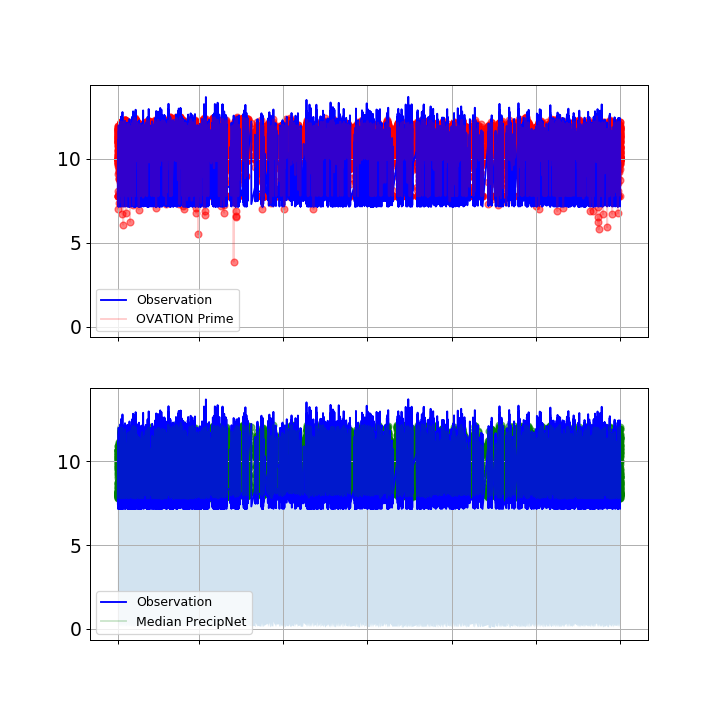

(array([733773., 733832., 733893., 733954., 734016., 734077., 734138.]),
 <a list of 7 Text xticklabel objects>)

In [98]:
# Plot OVP and ML predictions on separate subplots to see more clearly 

%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(8,8))
gs = GridSpec(2,1, figure=fig)


empty_string_labels = ['']*len(X_val.index)


# ax0 = fig.add_subplot(gs[0,0])
ax0 = plt.subplot(gs[0,0])
ax_out0 = ax0.plot(y_val.index,
                    y_val_log,
        #             y_val_erg,
                    c = 'b',
                    alpha = 1,
                    label='Observation'
                  )
ax_out0 = ax0.plot(y_val.index,
#                     y_val_ovation['model value'].values,
                    y_val_ovation['model value log10(ev/cm2/s)'].values,
                    c = 'r',#c = [240./255.,200./255.,8./255.,]
                    alpha =0.2,
                    label='OVATION Prime'
           )
ax_out2 = ax0.scatter(y_val_ovation.index,
#                     y_val_ovation['model value'],
                        y_val_ovation['model value log10(ev/cm2/s)'].values,
                        c = 'r',#c = [240./255.,200./255.,8./255.,]
                        alpha = 0.5,
                        s=30,
                        label='_nolegend_'
           )
plt.grid(True)
plt.legend()
ax0.set_xticklabels(empty_string_labels)


ax1 = plt.subplot(gs[1,0],sharex=ax0,sharey=ax0)


ax_out0 = ax1.plot(y_val.index,
                    y_val_log,
        #             y_val_erg,
                    c = 'b',
                    alpha = 1,
                    label='Observation'
                  )

# Fill between maximum and minimum values
ax1.fill_between(df_CV.index, 
                 df_CV['minimum'].values, 
                 df_CV['maximum'].values, 
#                  c='g',
                 alpha=0.2)

ax_out0 = ax1.plot(df_CV.index,
#                     y_val_ovation['model value'].values,
                    df_CV['median'].values,
                    c = 'g',#c = [240./255.,200./255.,8./255.,]
                    alpha =0.2,
                    label='Median PrecipNet'
           )
ax_out2 = ax1.scatter(df_CV.index,
                      df_CV['median'].values,
                        c = 'g',#c = [240./255.,200./255.,8./255.,]
                        alpha = 0.5,
                        s=30,
                        label='_nolegend_'
           )

plt.grid(True)
plt.legend()
ax1.set_xticklabels(empty_string_labels)


plt.legend()

plt.xticks(rotation=45)




<IPython.core.display.Javascript object>


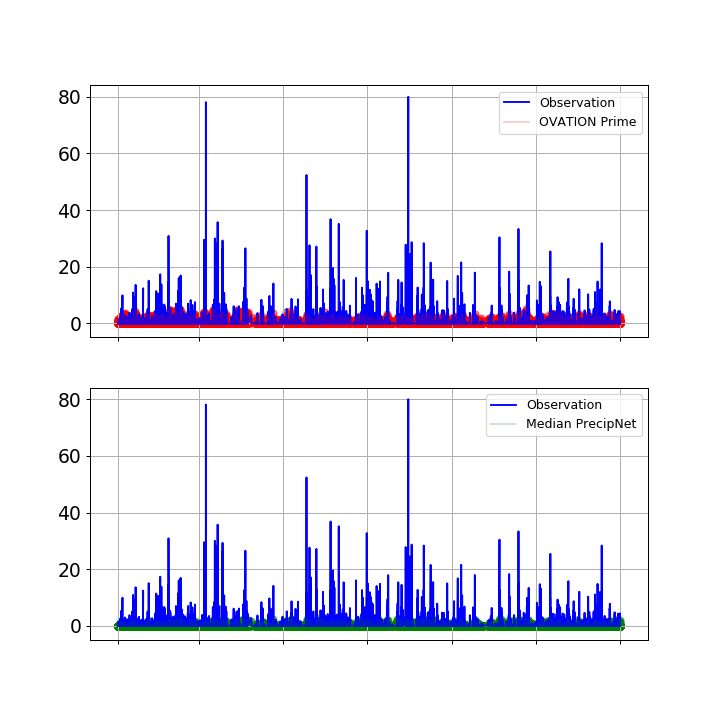

(array([733773., 733832., 733893., 733954., 734016., 734077., 734138.]),
 <a list of 7 Text xticklabel objects>)

In [95]:
# Plot OVP and ML predictions on separate subplots to see more clearly 

%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(8,8))
gs = GridSpec(2,1, figure=fig)


empty_string_labels = ['']*len(X_val.index)


# ax0 = fig.add_subplot(gs[0,0])
ax0 = plt.subplot(gs[0,0])
ax_out0 = ax0.plot(y_val.index,
#                     y_val_log,
                    y_val_erg,
                    c = 'b',
                    alpha = 1,
                    label='Observation'
                  )
ax_out0 = ax0.plot(y_val.index,
                    y_val_ovation['model value'].values,
#                     y_val_ovation['model value log10(ev/cm2/s)'].values,
                    c = 'r',#c = [240./255.,200./255.,8./255.,]
                    alpha =0.2,
                    label='OVATION Prime'
           )
ax_out2 = ax0.scatter(y_val_ovation.index,
                    y_val_ovation['model value'],
#                         y_val_ovation['model value log10(ev/cm2/s)'].values,
                        c = 'r',#c = [240./255.,200./255.,8./255.,]
                        alpha = 0.5,
                        s=30,
                        label='_nolegend_'
           )
plt.grid(True)
plt.legend()
ax0.set_xticklabels(empty_string_labels)


ax1 = plt.subplot(gs[1,0],sharex=ax0,sharey=ax0)


ax_out0 = ax1.plot(y_val.index,
#                     y_val_log,
                    y_val_erg,
                    c = 'b',
                    alpha = 1,
                    label='Observation'
                  )

# Fill between maximum and minimum values
ax1.fill_between(df_CV.index, 
#                  df_CV['minimum'].values, 
                 10**(df_CV['minimum'].values)* erg_eV_factor,
#                  df_CV['maximum'].values, 
                 10**(df_CV['maximum'].values)* erg_eV_factor,
#                  c='g',
                 alpha=0.2)

ax_out0 = ax1.plot(df_CV.index,
#                     df_CV['median'].values,
                    10**(df_CV['median'].values)* erg_eV_factor,
                    c = 'g',#c = [240./255.,200./255.,8./255.,]
                    alpha =0.2,
                    label='Median PrecipNet'
           )
ax_out2 = ax1.scatter(df_CV.index,
#                       df_CV['median'].values,
                      10**(df_CV['median'].values)* erg_eV_factor,
                        c = 'g',#c = [240./255.,200./255.,8./255.,]
                        alpha = 0.5,
                        s=30,
                        label='_nolegend_'
           )

plt.grid(True)
plt.legend()
ax1.set_xticklabels(empty_string_labels)


plt.legend()

plt.xticks(rotation=45)




In [44]:
df_val_LTIMEs = df_cumulative_LTIMEs[mask_val[0]].copy(deep=True)


In [85]:
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

<IPython.core.display.Javascript object>


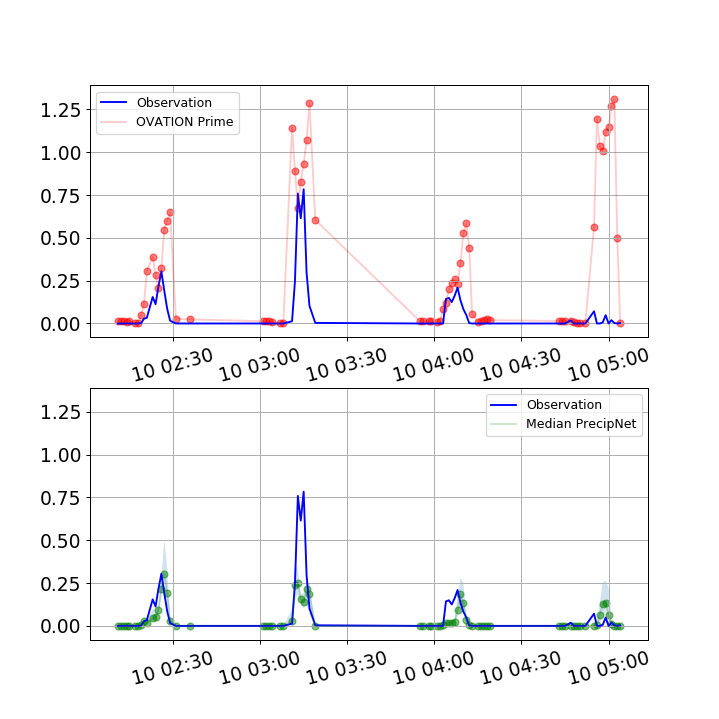

2 (74, 1)


<IPython.core.display.Javascript object>


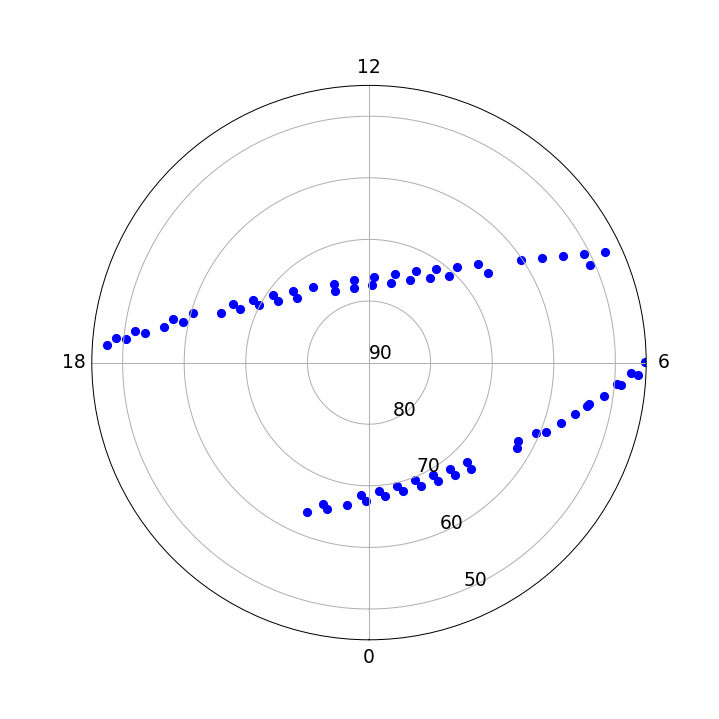

In [86]:
# Plot OVP and ML predictions on separate subplots to see more clearly 

# %matplotlib notebook
import matplotlib.pyplot as plt
# plt.ioff()

fig = plt.figure(figsize=(8,8))
gs = GridSpec(2,1, figure=fig)

datetime_range2 = [datetime.datetime(2010,12,10,1),datetime.datetime(2010,12,10,7)]
zoom_range2 = np.argwhere( (X_val.index>=datetime_range2[0]) & (X_val.index<=datetime_range2[1]) )

print(len(datetime_range2),zoom_range2.shape)
empty_string_labels = ['']*len(X_val.index)
# ax0 = fig.add_subplot(gs[0,0])
ax0 = plt.subplot(gs[0,0])
ax_out0 = ax0.plot(y_val.index[zoom_range2[0][0]:zoom_range2[-1][0]],
#                     y_val_log[zoom_range2[0][0]:zoom_range2[-1][0]],
                    y_val_erg[zoom_range2[0][0]:zoom_range2[-1][0]],
                    c = 'b',
                    alpha = 1,
                    label='Observation'
                  )

ax_out0 = ax0.plot(y_val.index[zoom_range2[0][0]:zoom_range2[-1][0]],
                    y_val_ovation['model value'].values[zoom_range2[0][0]:zoom_range2[-1][0]],
#                     y_val_ovation['model value log10(ev/cm2/s)'].values[zoom_range2[0][0]:zoom_range2[-1][0]],
                    c = 'r',#c = [240./255.,200./255.,8./255.,]
                    alpha =0.2,
                    label='OVATION Prime'
           )
ax_out2 = ax0.scatter(y_val_ovation.index[zoom_range2[0][0]:zoom_range2[-1][0]],
                    y_val_ovation['model value'].values[zoom_range2[0][0]:zoom_range2[-1][0]],
#                         y_val_ovation['model value log10(ev/cm2/s)'].values[zoom_range2[0][0]:zoom_range2[-1][0]],
                        c = 'r',#c = [240./255.,200./255.,8./255.,]
                        alpha = 0.5,
                        s=30,
                        label='_nolegend_'
           )
plt.grid(True)
plt.legend()
plt.xticks(rotation=15)

# ax0.set_xticklabels(empty_string_labels)


ax1 = plt.subplot(gs[1,0],sharex=ax0,sharey=ax0)


ax_out0 = ax1.plot(y_val.index[zoom_range2[0][0]:zoom_range2[-1][0]],
#                     y_val_log[zoom_range2[0][0]:zoom_range2[-1][0]],
                    y_val_erg[zoom_range2[0][0]:zoom_range2[-1][0]],
                    c = 'b',
                    alpha = 1,
                    label='Observation'
                  )

# Fill between maximum and minimum values
ax1.fill_between(df_CV.index[zoom_range2[0][0]:zoom_range2[-1][0]], 
                 10**(df_CV['minimum'].values[zoom_range2[0][0]:zoom_range2[-1][0]])* erg_eV_factor,
                 10**(df_CV['maximum'].values[zoom_range2[0][0]:zoom_range2[-1][0]])* erg_eV_factor,
#                  c='g',
                 alpha=0.2)

ax_out0 = ax1.plot(df_CV.index[zoom_range2[0][0]:zoom_range2[-1][0]],
                    10**(df_CV['median'].values[zoom_range2[0][0]:zoom_range2[-1][0]])* erg_eV_factor,
                    c = 'g',#c = [240./255.,200./255.,8./255.,]
                    alpha =0.2,
                    label='Median PrecipNet'
           )
ax_out2 = ax1.scatter(df_CV.index[zoom_range2[0][0]:zoom_range2[-1][0]],
                      10**(df_CV['median'].values[zoom_range2[0][0]:zoom_range2[-1][0]])* erg_eV_factor,
                        c = 'g',#c = [240./255.,200./255.,8./255.,]
                        alpha = 0.5,
                        s=30,
                        label='_nolegend_'
           )

plt.grid(True)
plt.legend()
# ax1.set_xticklabels(empty_string_labels)


plt.legend()

plt.xticks(rotation=15)





#----------------------------------------------------------------------------------------------------------------
# POLAR PLOT

fig = plt.figure(figsize=(8,8))
gs = GridSpec(1,1, figure=fig)
ax0 = plt.subplot(gs[0,0],polar=True)

ax_out0 = ax0.scatter(df_val_LTIMEs.values[zoom_range2[0][0]:zoom_range2[-1][0]]*15.* (np.pi/180.), 
                      90. - X_val['SC_AACGM_LAT'][zoom_range2[0][0]:zoom_range2[-1][0]],
                      s = 40,
                      c = 'b')

# define your axis limits
ax0.set_ylim([0,45])

# Set the radius labels
ax0.set_yticks(np.arange(0,50,10))  # less radial ticks
ax0.set_yticklabels(90 - np.arange(0,50,10))  # less radial ticks

# Set the circumference labels
ax0.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
ax0.set_xticklabels(('0','6','12','18'))      

ax0.grid(True)
ax0.set_theta_zero_location("S")

#----------------------------------------------------------------------------------------------------------------


plt.show()

In [69]:
df_metrics_CV_val_median#[i]


iteration           4.500000
MAE                 0.556360
MSE                 0.581088
RMSE                0.762291
RAE                 0.401977
RSE                 0.247796
RSQ                 0.752204
linear slope        0.721504
linear intercept    2.582535
dtype: float64

In [87]:
df_metrics_CV_val

df_metrics_CV_val_median = df_metrics_CV_val.median(axis=0)
df_metrics_CV_val_minimum = df_metrics_CV_val.min(axis=0)
df_metrics_CV_val_maximum = df_metrics_CV_val.max(axis=0)
df_metrics_CV_val_mean = df_metrics_CV_val.mean(axis=0)
df_metrics_CV_val_stdev = df_metrics_CV_val.std(axis=0)

for i in df_metrics_CV_val_median.index:
    if i == 'iteration':
        continue
    print('{}   {:.3F} +/- {:.2F}'.format(i,df_metrics_CV_val_median[i],df_metrics_CV_val_stdev[i]))


MAE   0.556 +/- 0.04
MSE   0.581 +/- 0.04
RMSE   0.762 +/- 0.03
RAE   0.402 +/- 0.03
RSE   0.248 +/- 0.02
RSQ   0.752 +/- 0.02
linear slope   0.722 +/- 0.04
linear intercept   2.583 +/- 0.42


In [88]:
df_metrics_CV_val

,iteration,MAE,MSE,RMSE,RAE,RSE,RSQ,linear slope,linear intercept
0,0,0.557694,0.583701,0.764003,0.402941,0.248911,0.751089,0.719142,2.55179
1,1,0.545323,0.575423,0.758567,0.394003,0.245381,0.754619,0.738442,2.40543
2,2,0.559754,0.581624,0.762643,0.404429,0.248025,0.751975,0.702716,2.73827
3,3,0.555026,0.578241,0.760422,0.401014,0.246582,0.753418,0.720516,2.63216
4,4,0.54445,0.580118,0.761655,0.393372,0.247383,0.752617,0.749609,2.36749
5,5,0.634047,0.667127,0.816779,0.458107,0.284486,0.715514,0.667859,3.28403
6,6,0.653093,0.685926,0.828207,0.471869,0.292503,0.707497,0.624249,3.61545
7,7,0.541471,0.580553,0.76194,0.39122,0.247568,0.752432,0.760342,2.28045
8,8,0.558262,0.589417,0.767735,0.403351,0.251348,0.748652,0.735981,2.52936
9,9,0.549289,0.576303,0.759147,0.396868,0.245756,0.754244,0.722491,2.61328


In [89]:
df_CV.columns

Index(['CV0', 'CV1', 'CV2', 'CV3', 'CV4', 'CV5', 'CV6', 'CV7', 'CV8', 'CV9',
       'median', 'minimum', 'maximum', 'stdev'],
      dtype='object')

<IPython.core.display.Javascript object>


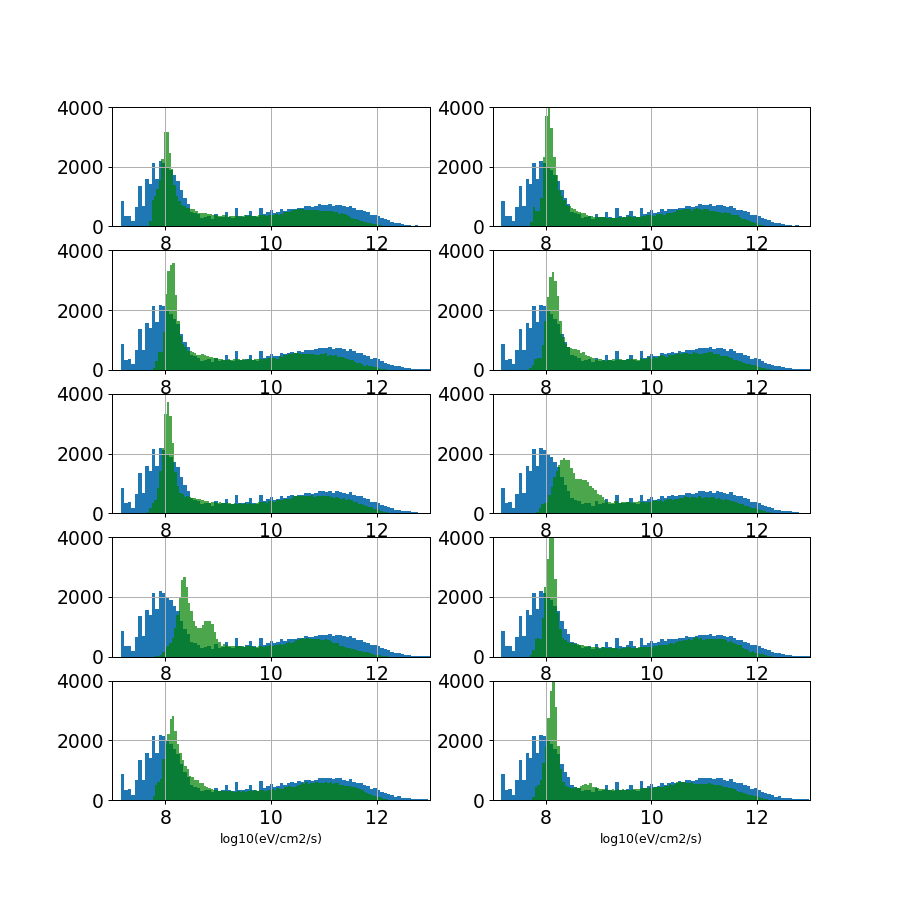

In [93]:
num_bins_plot = 100
fig = plt.figure(figsize=(10,10))
gs = GridSpec(5,2, figure=fig)
    
ctr = 0
for i in df_CV_columns:


    ax0 = fig.add_subplot(gs[ctr])
    ax0.hist(y_val_log,
             label= 'Observed validation',
             bins = num_bins_plot)
    # plt.ylabel('Validation: obs')
    plt.ylim([0,4000])
    plt.xlim([7,13])
    plt.grid(True)
    plt.xlabel('log10(eV/cm2/s)')


    ax0.hist(
             df_CV[i].values,
             bins = num_bins_plot,
             alpha = 0.7,
             color='g',
             label='NN validation prediction')

#     plt.legend()
    
    ctr +=1

<IPython.core.display.Javascript object>


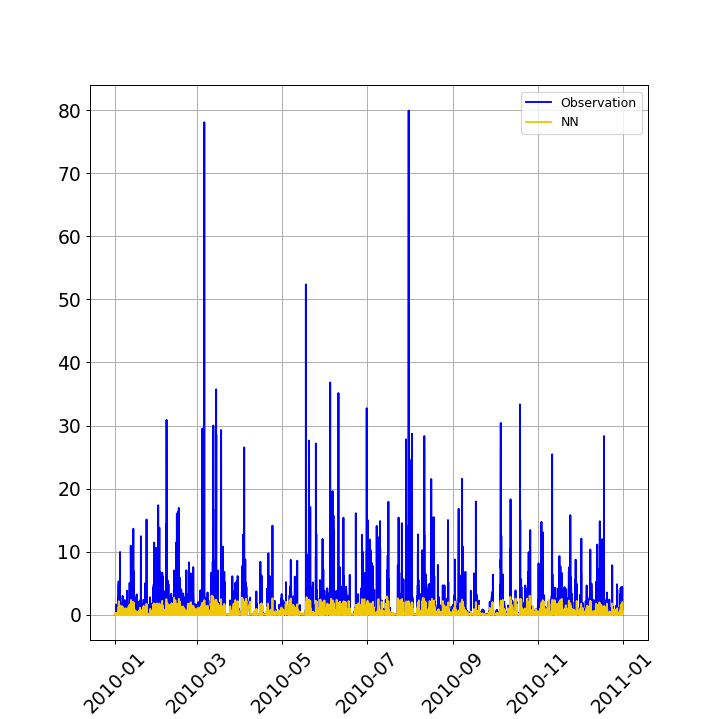

(array([733773., 733832., 733893., 733954., 734016., 734077., 734138.]),
 <a list of 7 Text xticklabel objects>)

In [94]:
# Plot OVP and ML predictions on separate subplots to see more clearly 

%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(8,8))
gs = GridSpec(1,1, figure=fig)


empty_string_labels = ['']*len(X_val.index)


# ax0 = fig.add_subplot(gs[0,0])
ax0 = plt.subplot(gs[0,0])
ax_out0 = ax0.plot(X_val.index,
#             y_val_log,
            y_val_erg,
            c = 'b',
            alpha = 1,
            label='Observation'
           )
ax_out1 = ax0.plot(X_val.index,
            10**(df_CV['CV7'].values) * (1.60218e-12),
            c = [240./255.,200./255.,8./255.,],
            alpha =1,
            label='NN'
           )

plt.grid(True)
plt.legend()
# ax2.set_xticklabels(empty_string_labels)


plt.legend()

plt.xticks(rotation=45)




<IPython.core.display.Javascript object>


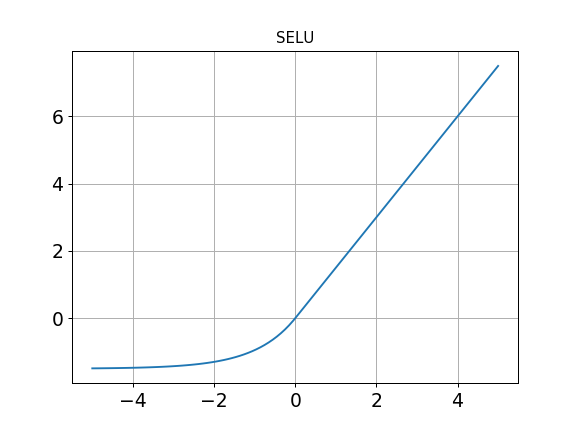

Text(0.5, 1.0, 'SELU')

In [91]:

def fun(x,lamb,alph):
    if x <= 0:
        y = lamb* ((alph)*np.exp(x) - (alph))
    elif x>0:
        y = lamb*x
    return y
    
vfun = np.vectorize(fun)
x = np.linspace(-5,5,100)
y = vfun(x,1.5,1)

plt.figure()
plt.plot(x,y)
plt.grid(True)
plt.title('SELU')
